In [6]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro
from sklearn.model_selection import GridSearchCV
import gc
import itertools
from sklearn.utils import resample
import ast
import json
import re
import statsmodels.api as sm

import utils 
import model_train
from constants import *
import particle_swarm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Set your folder path
folder_path = '/Users/yusiwei/Library/CloudStorage/OneDrive-Personal/research/Fourth Year Paper/Experiments/2nd experiments/Experiment results/V1/V4/Tracking info/'

# Get all files (not directories) in the folder
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Define a regex pattern to extract k, n_cluster, and model name
pattern = r'track_info_k(\d+)_ncluster(\d+)_([^.]+)\.csv'


k: 20, n_cluster: 30, ML model: NB


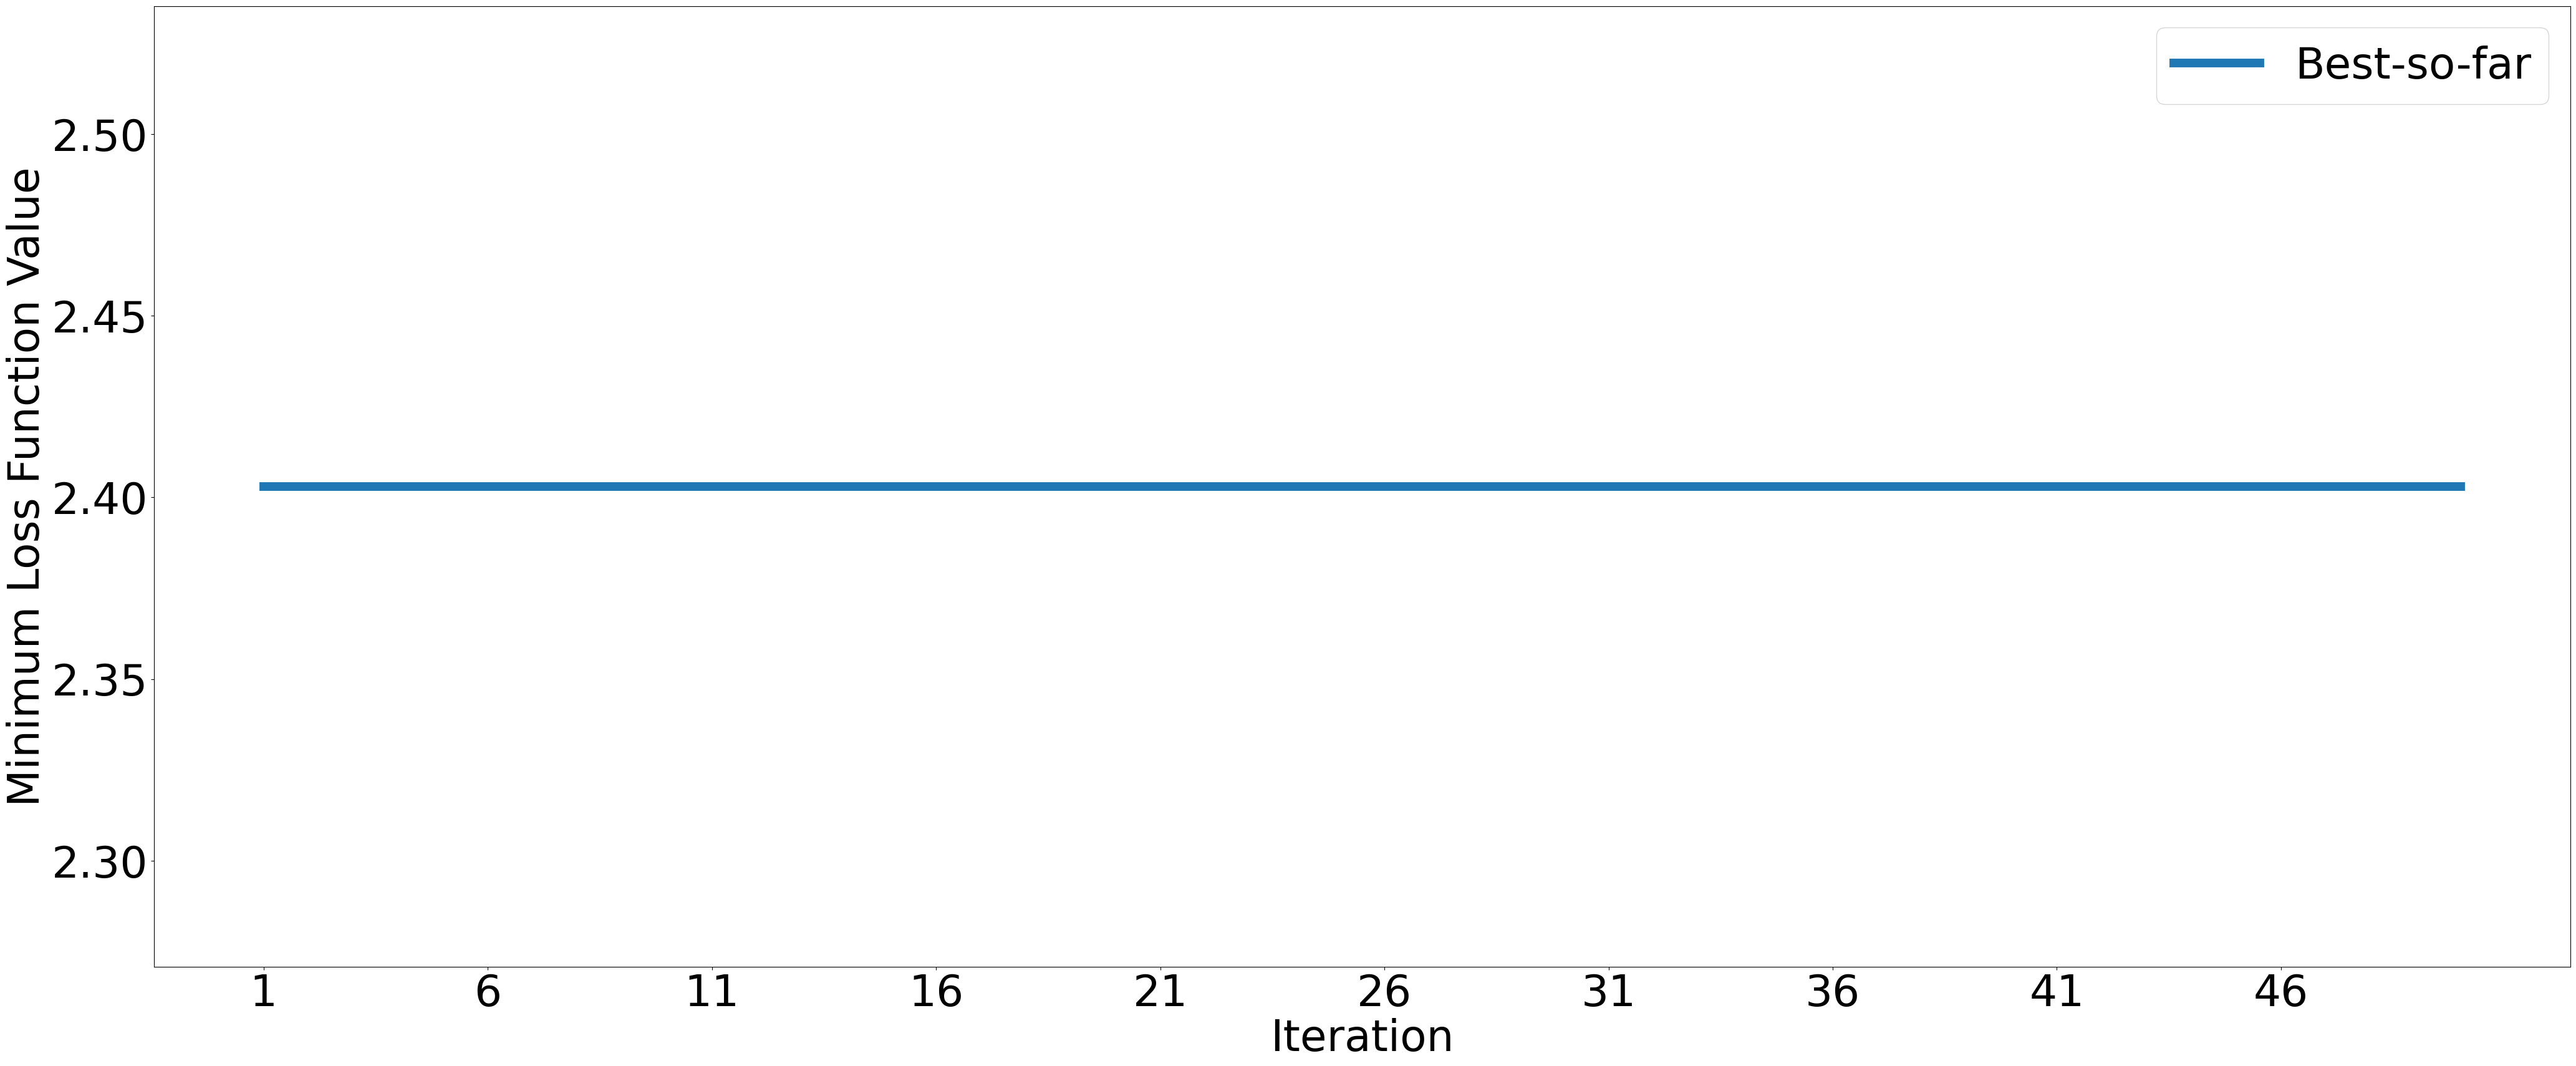

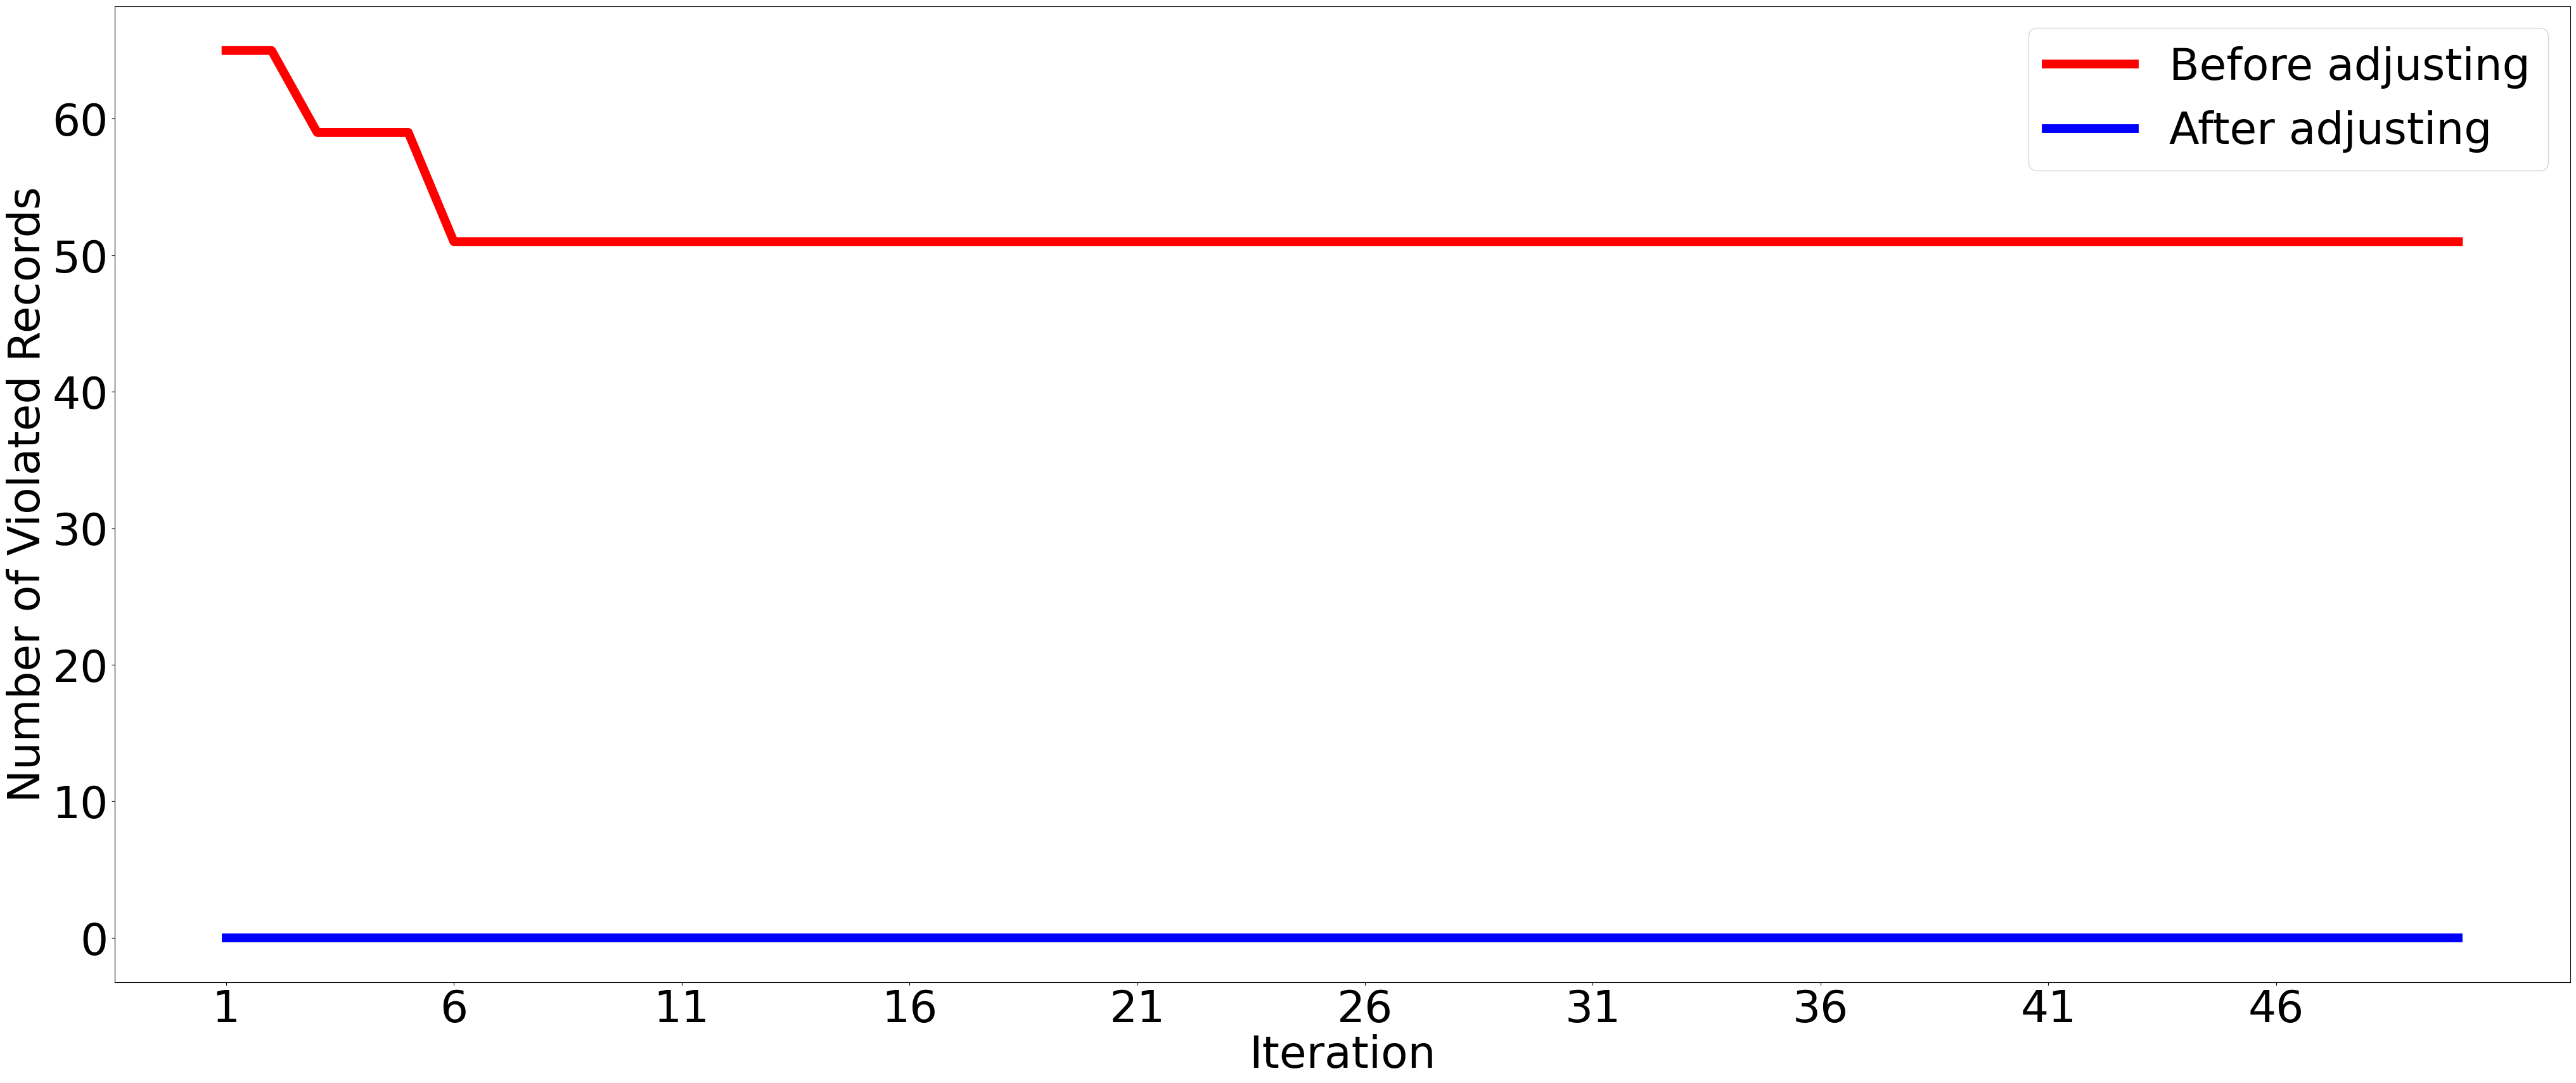

k: 20, n_cluster: 10, ML model: DT


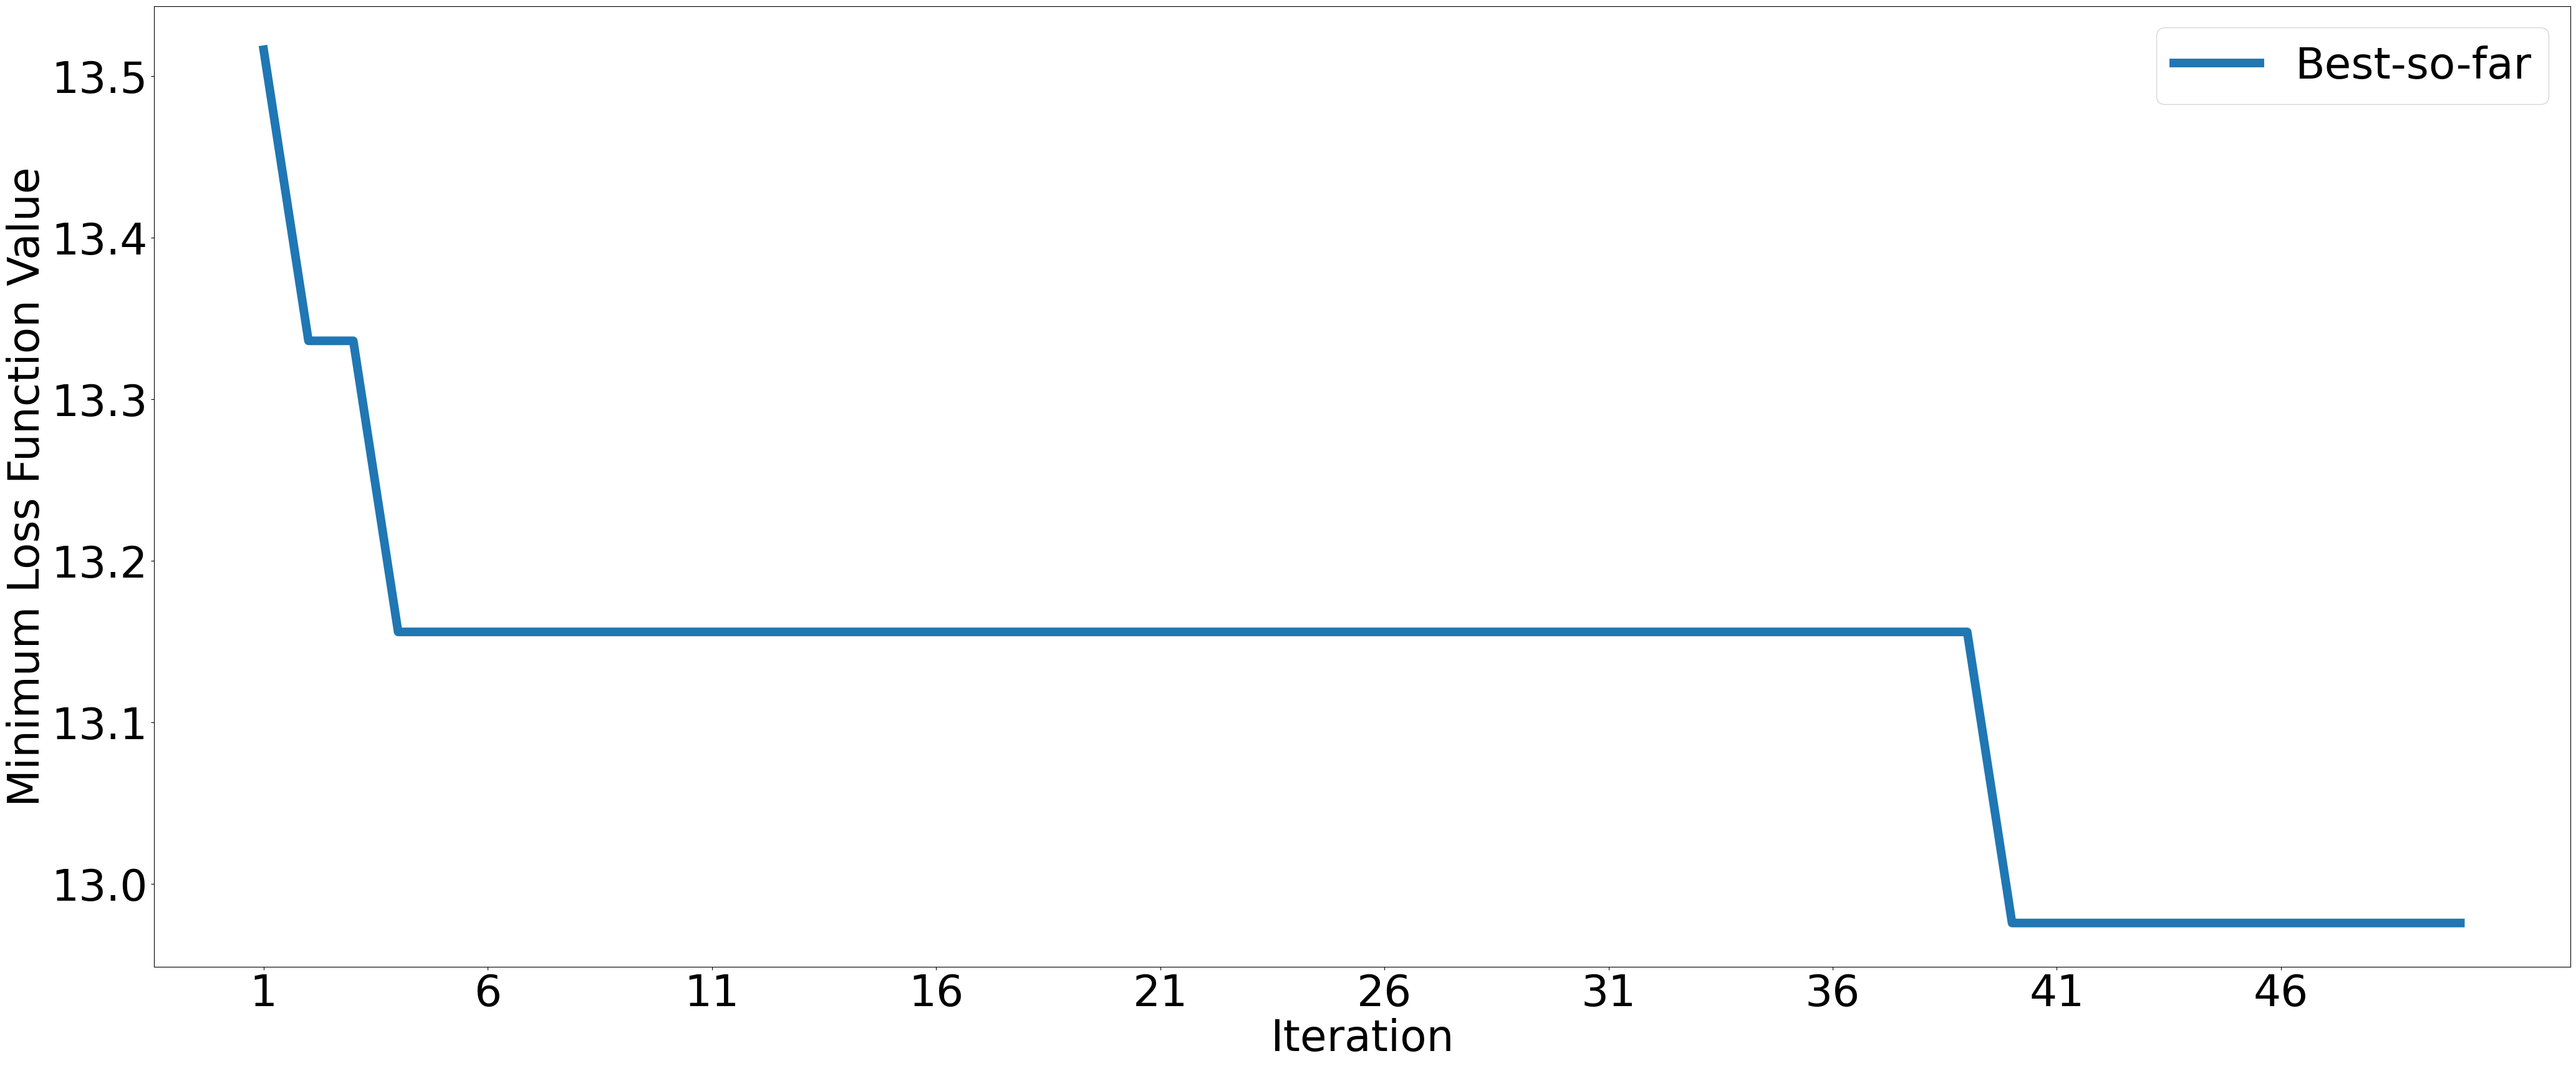

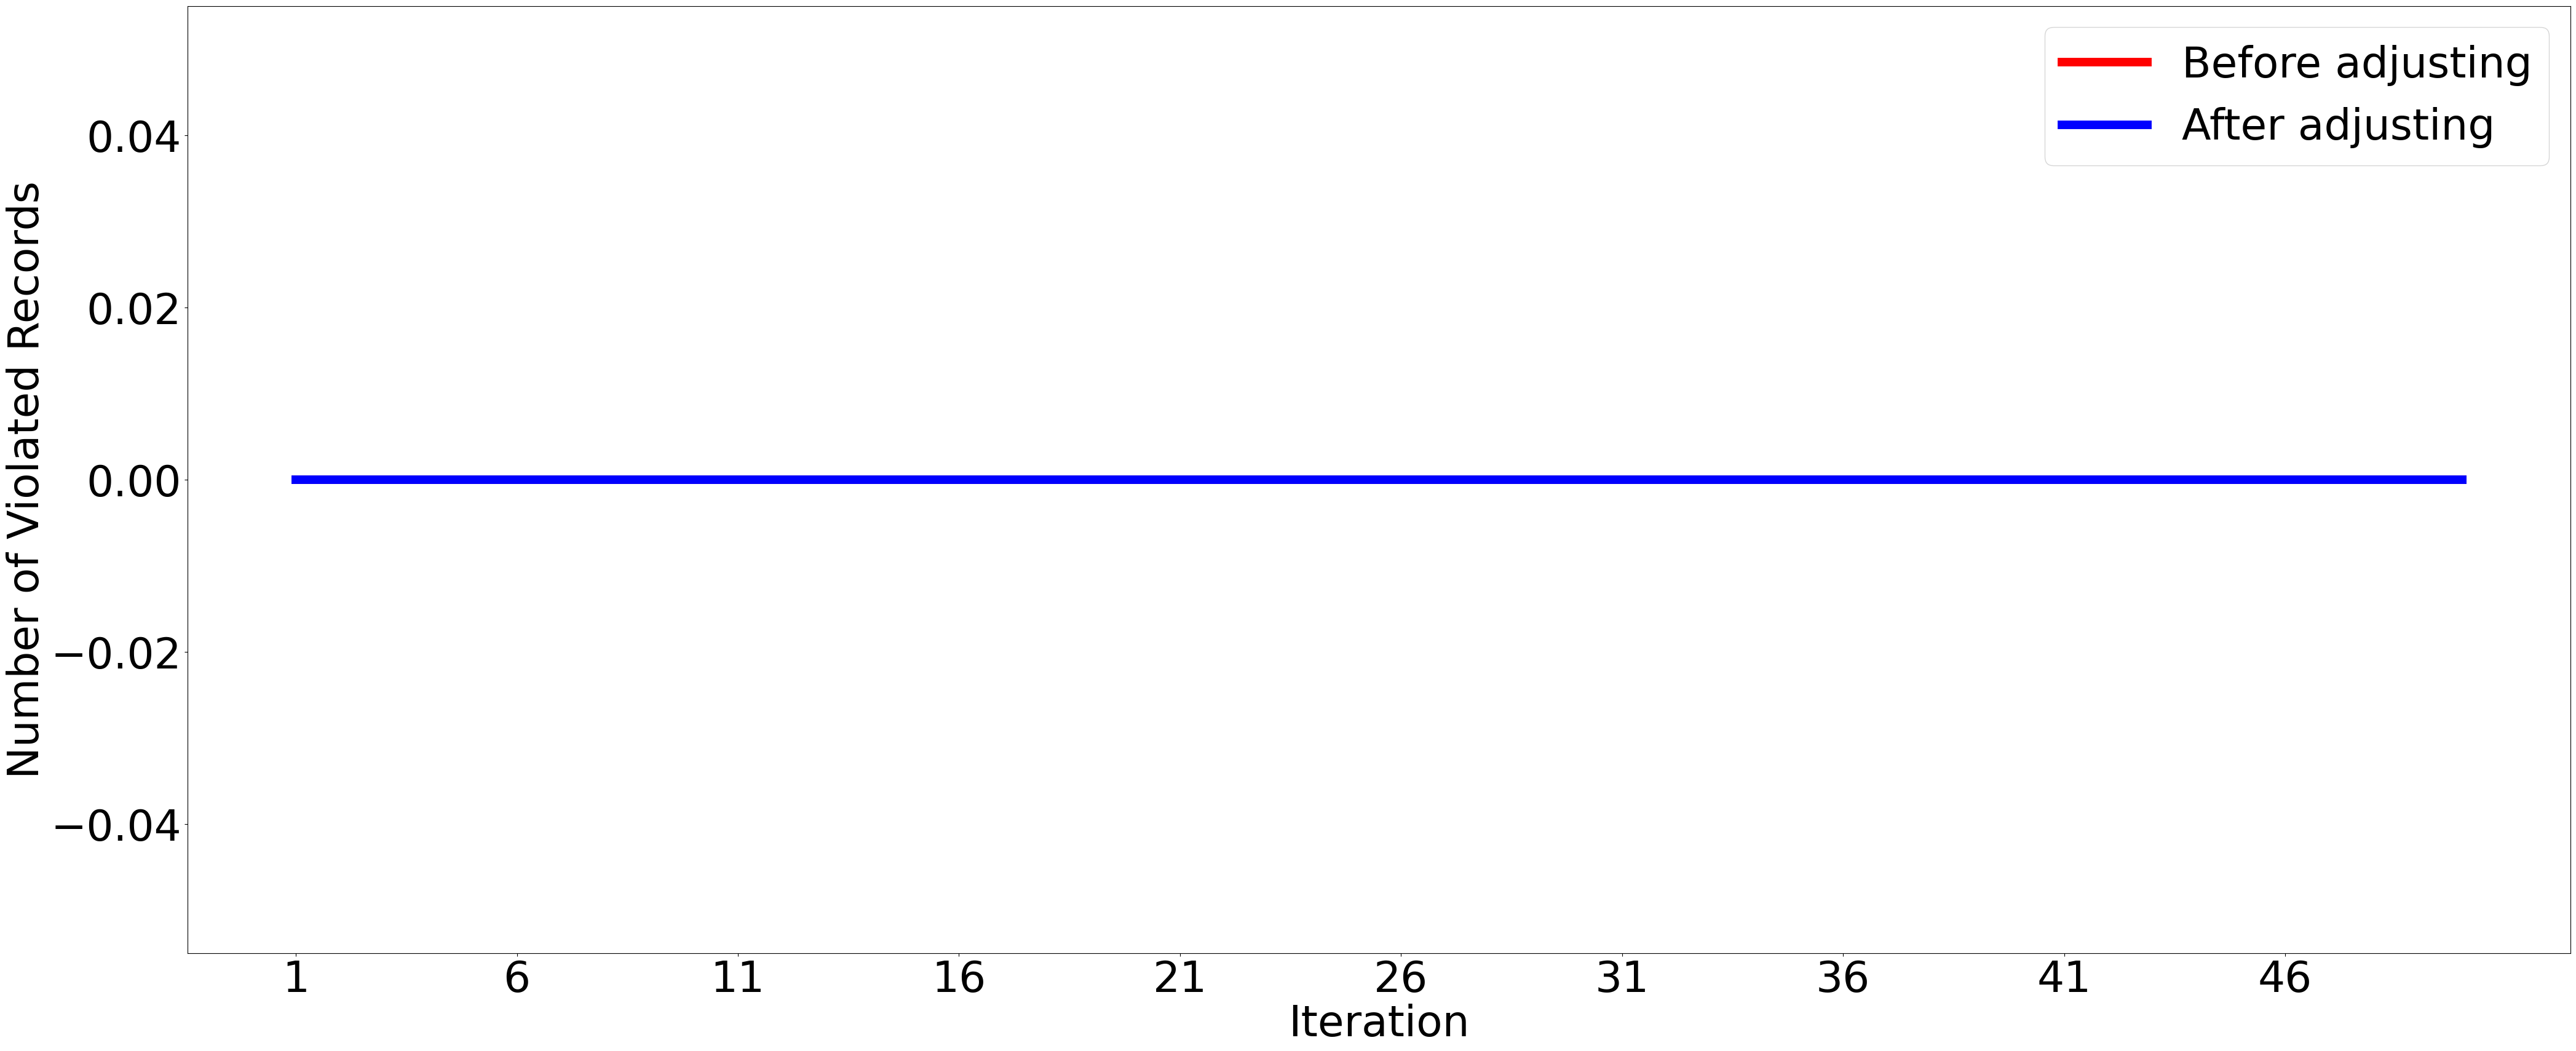

k: 20, n_cluster: 20, ML model: NB


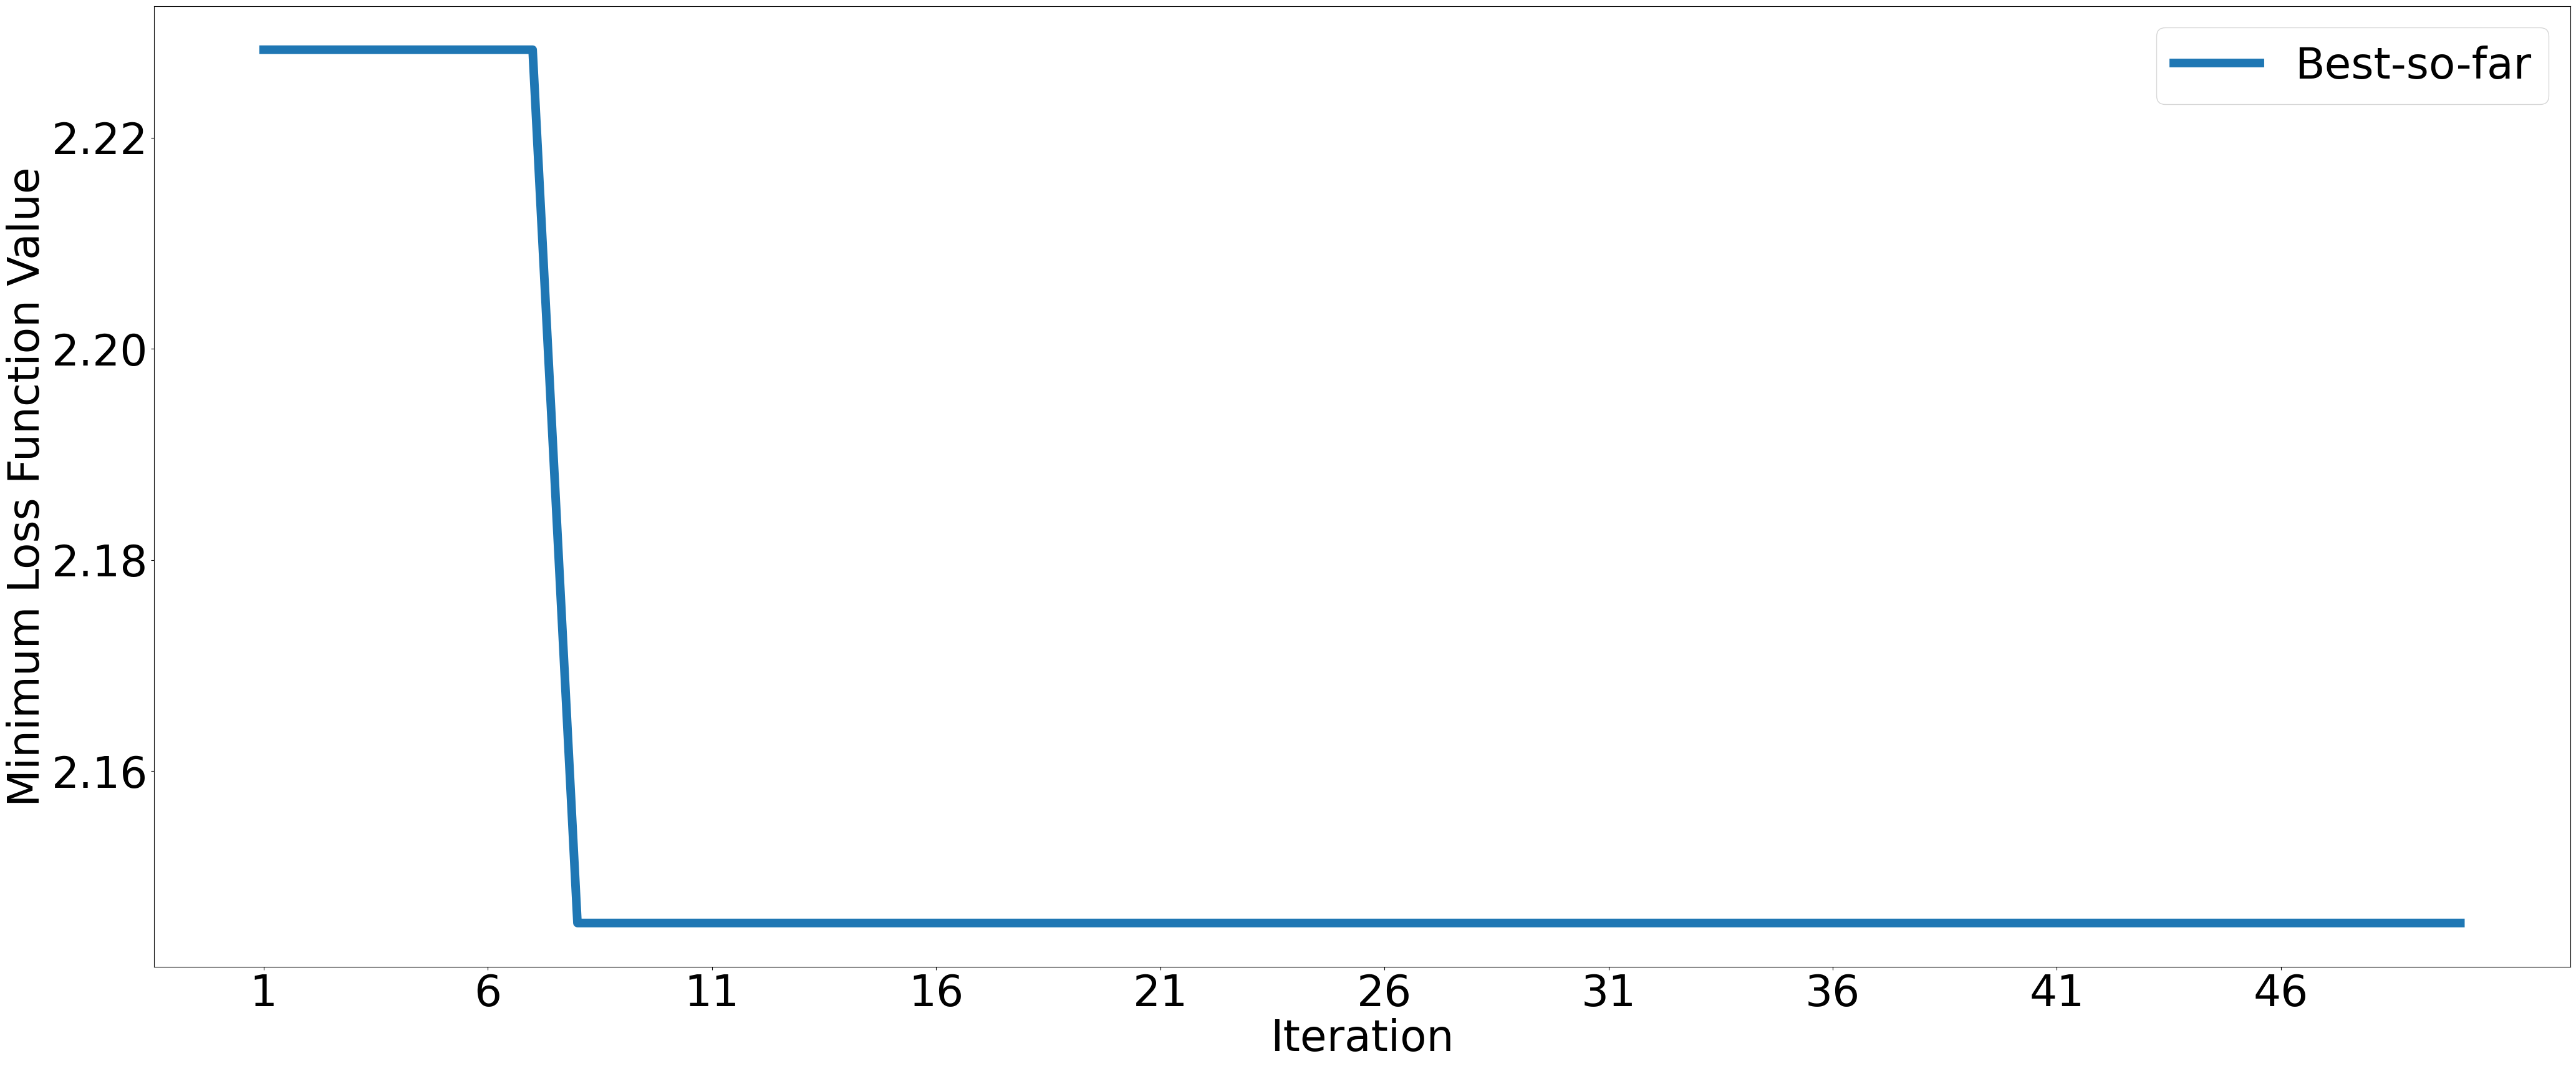

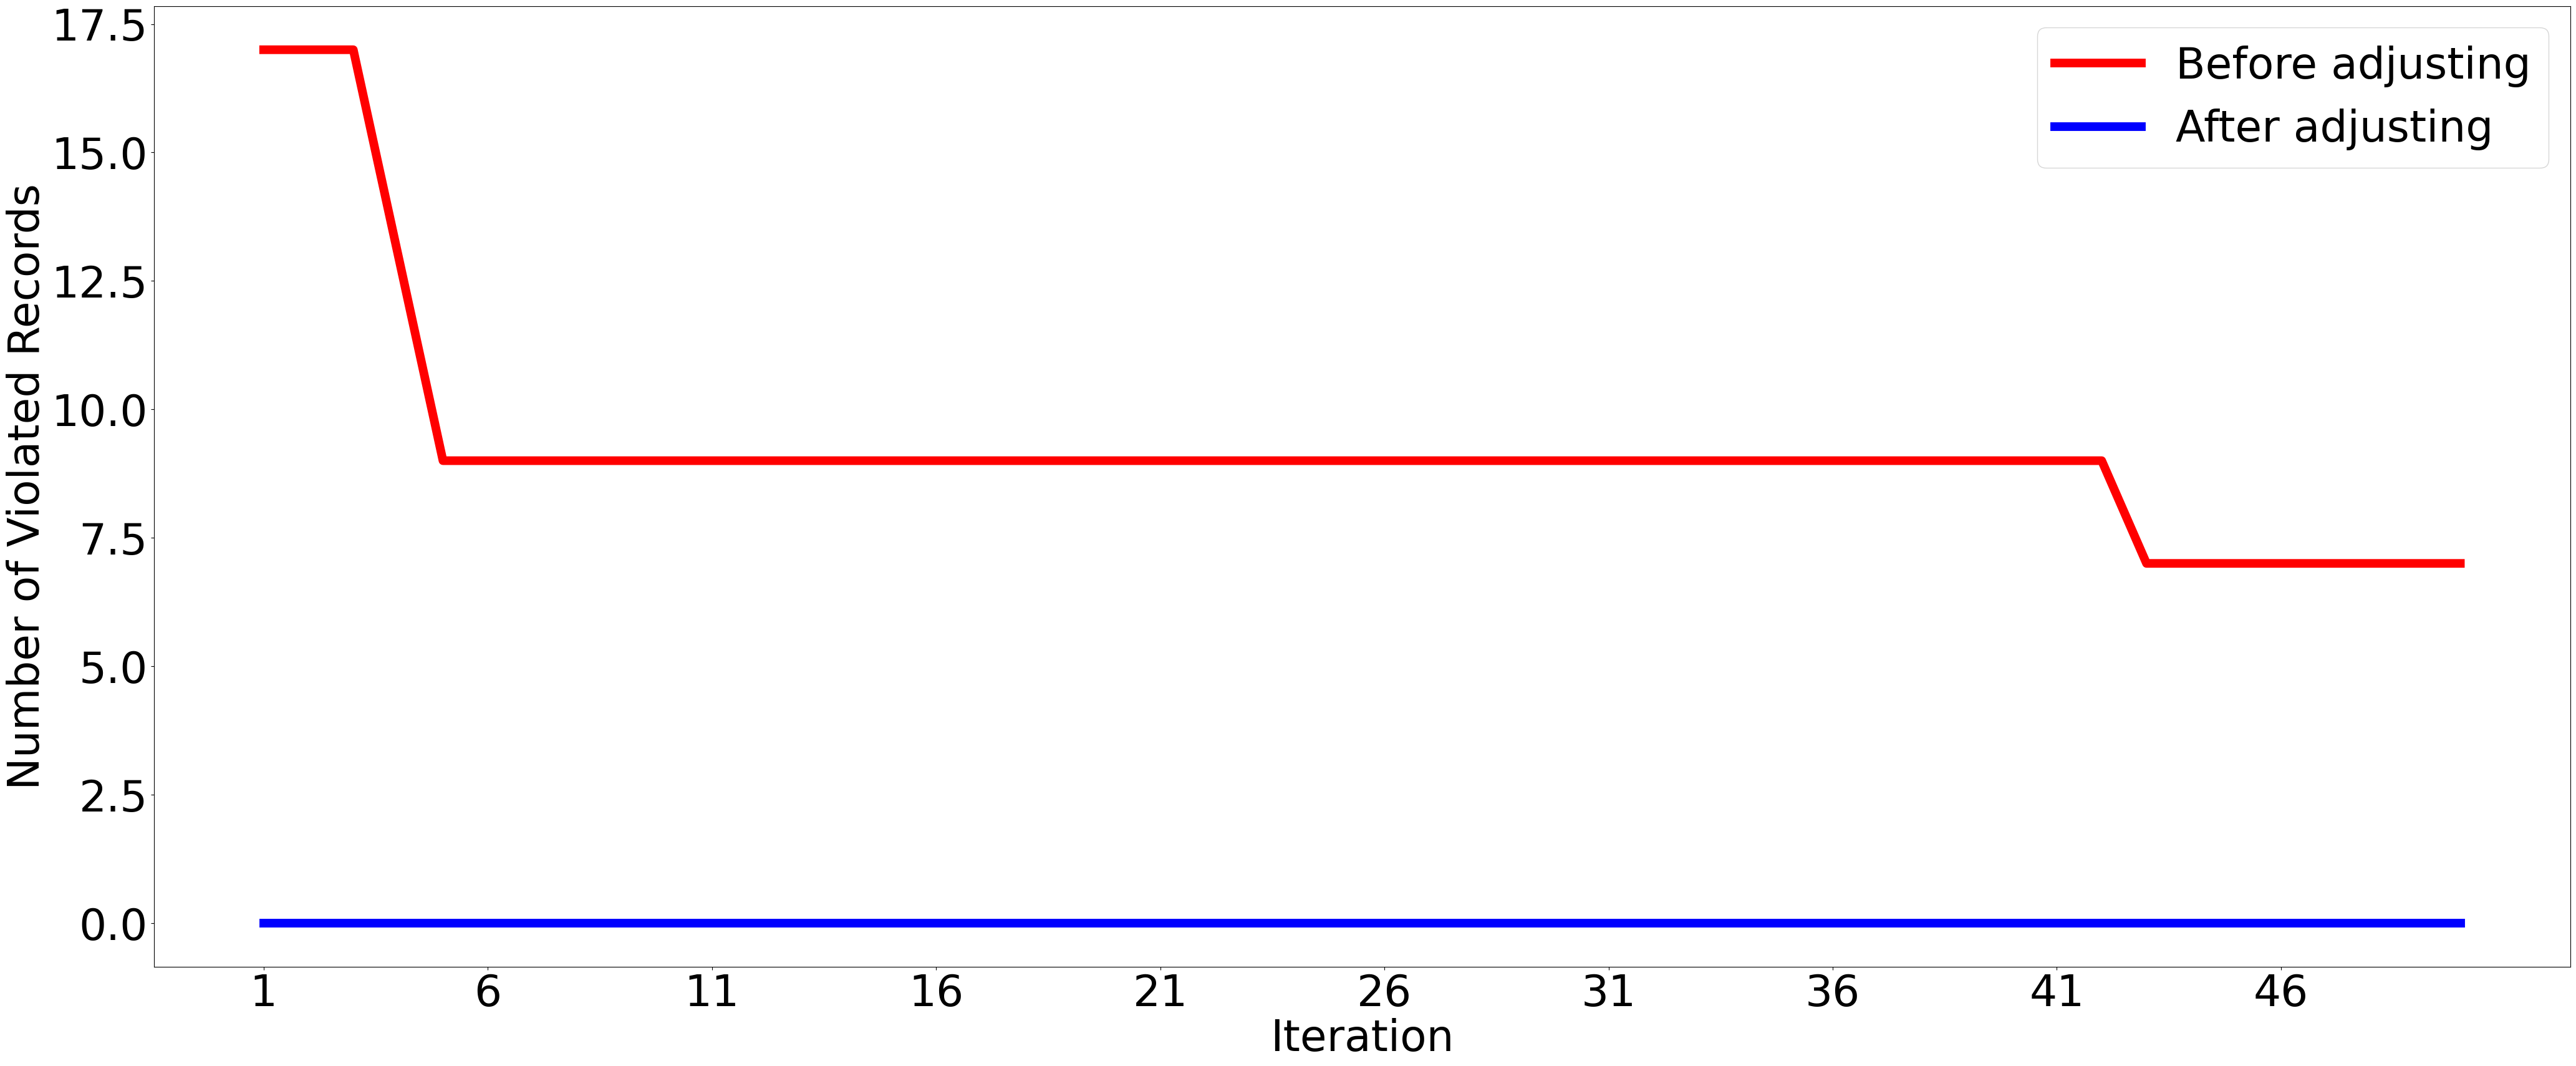

k: 20, n_cluster: 30, ML model: DT


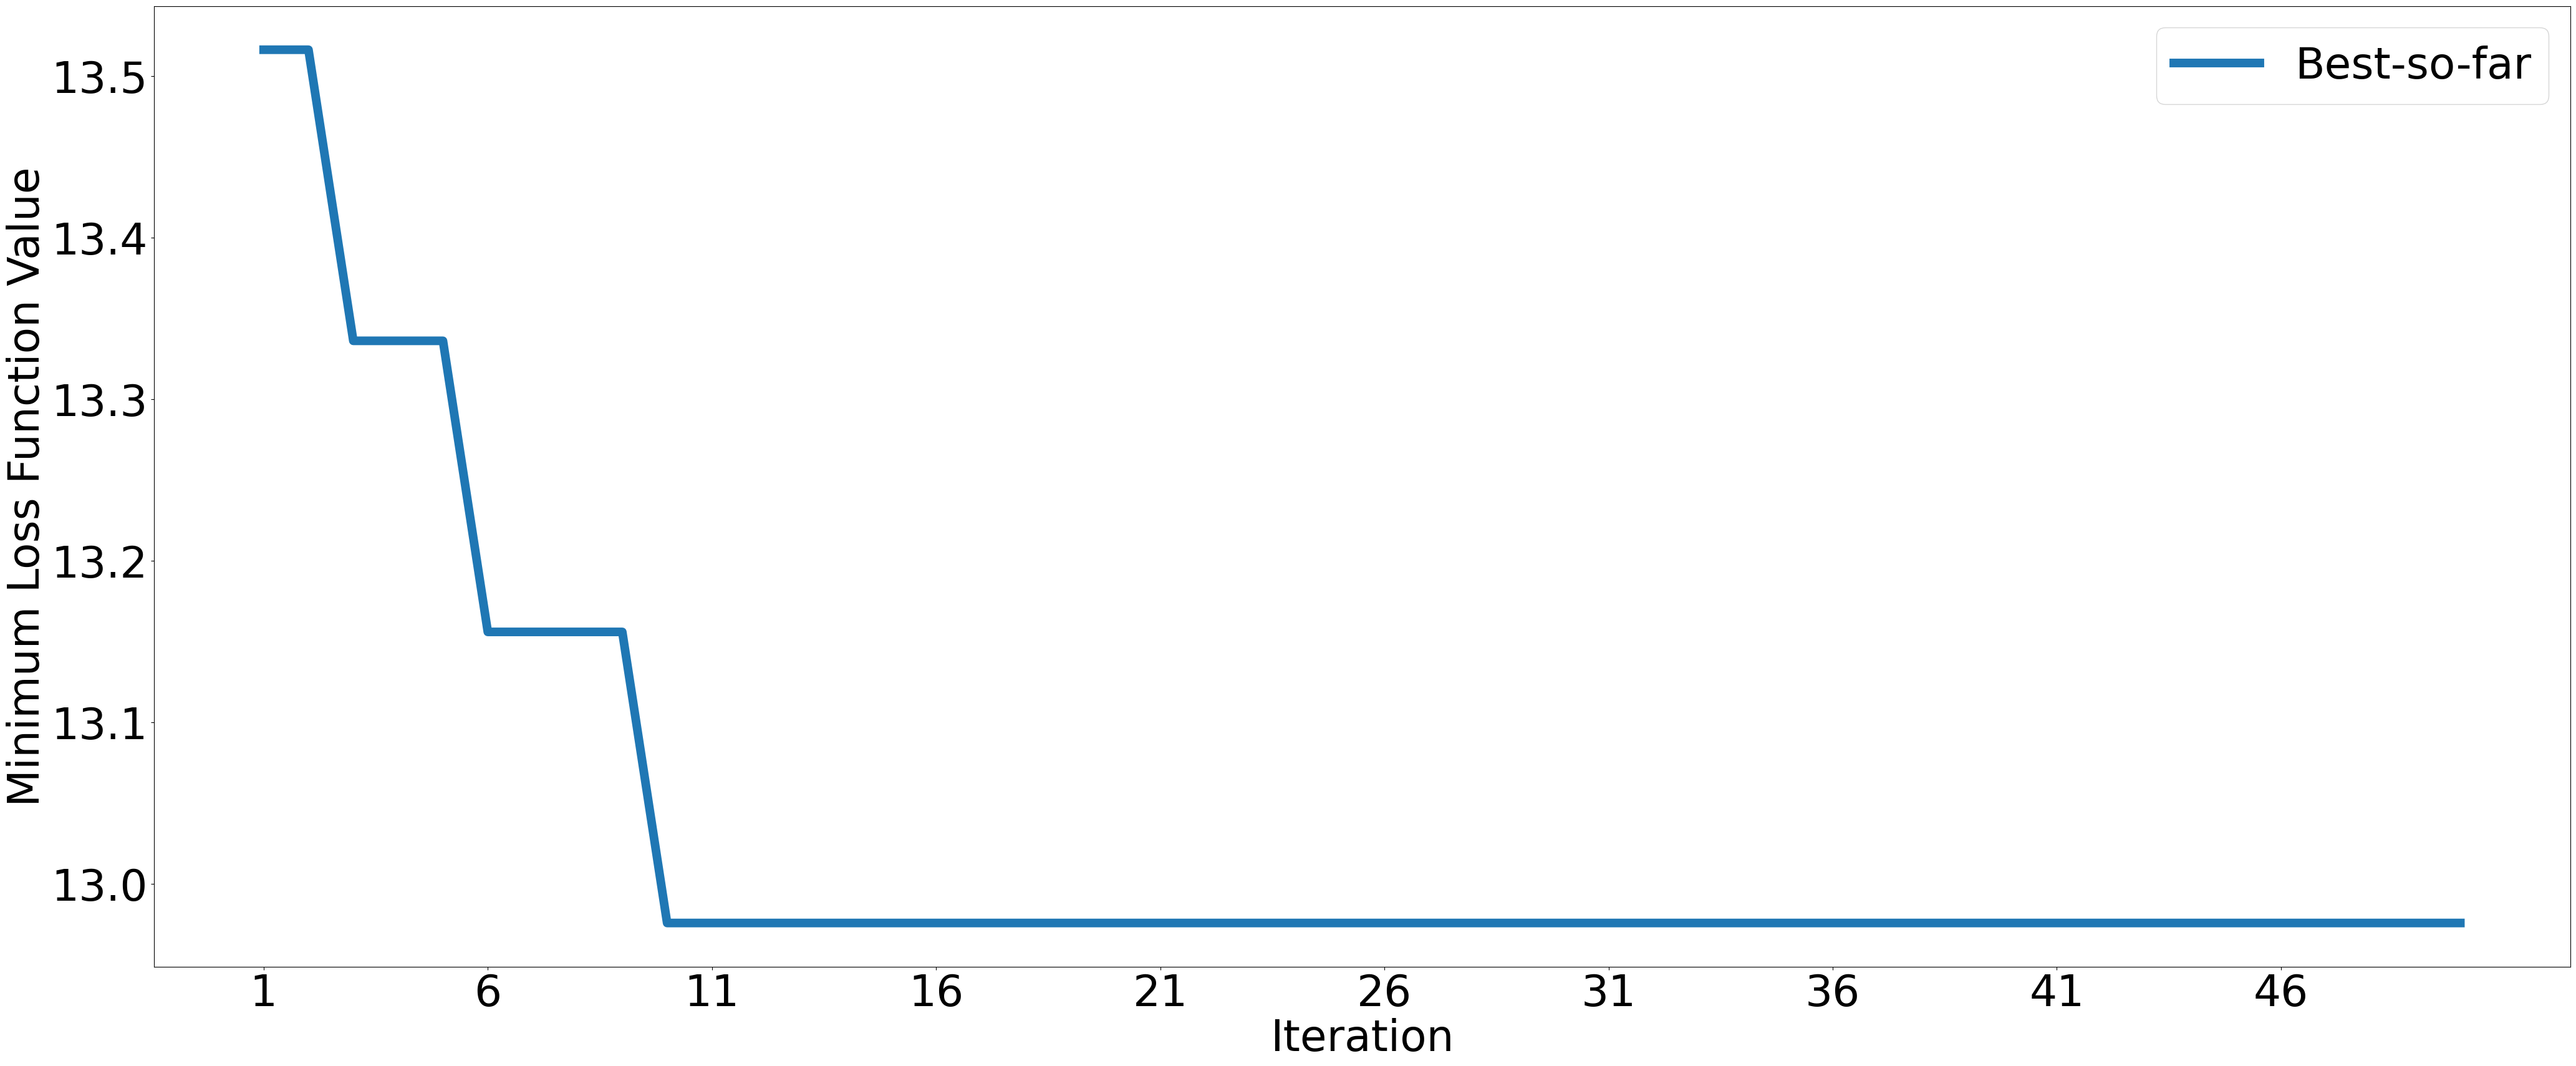

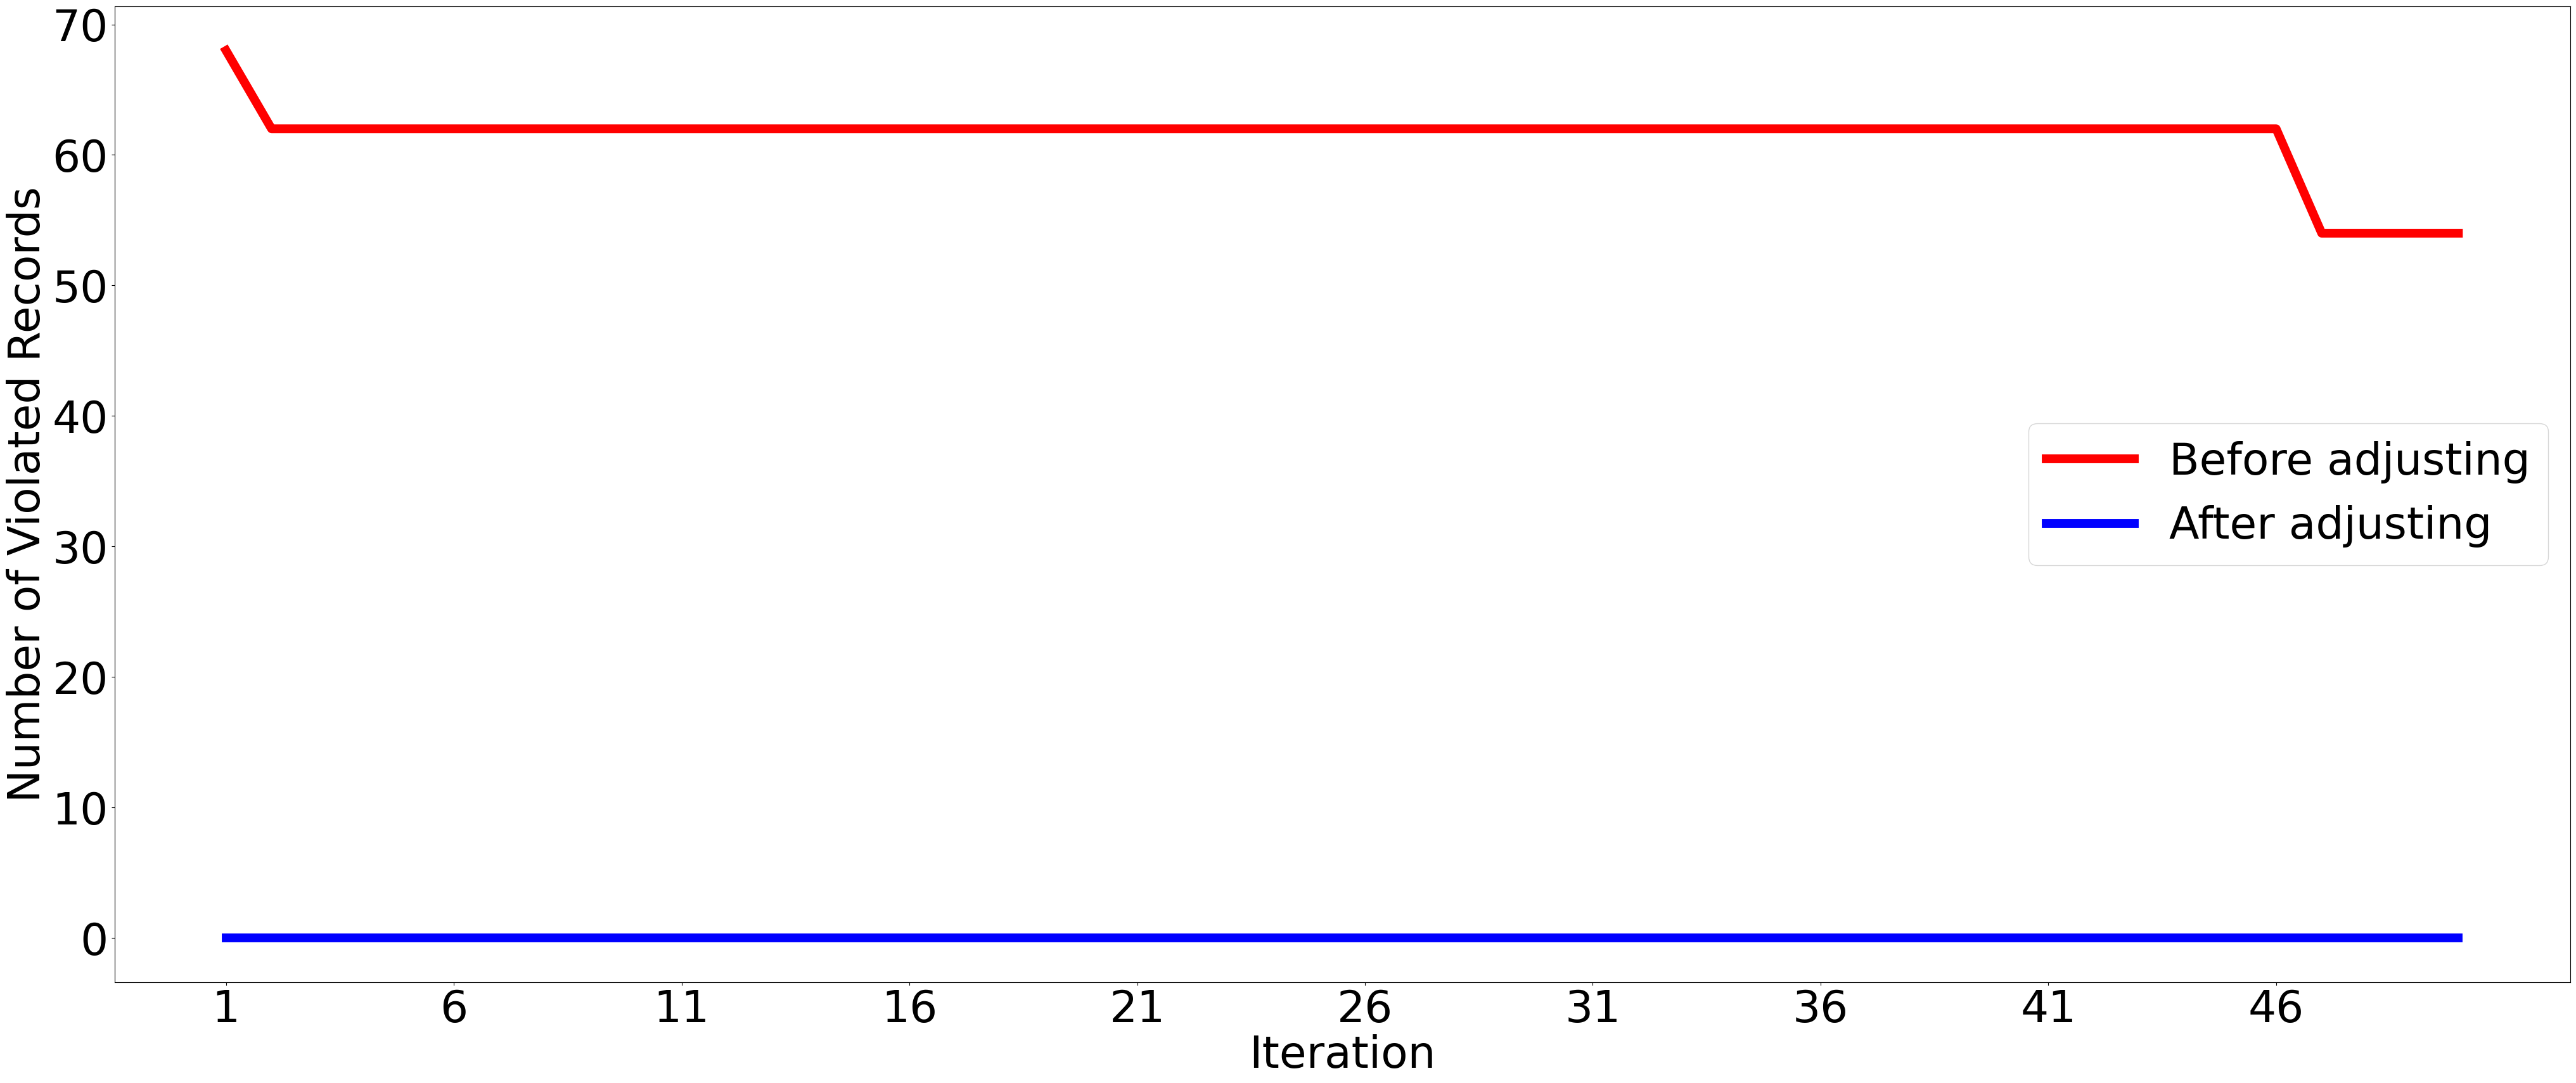

k: 20, n_cluster: 10, ML model: NB


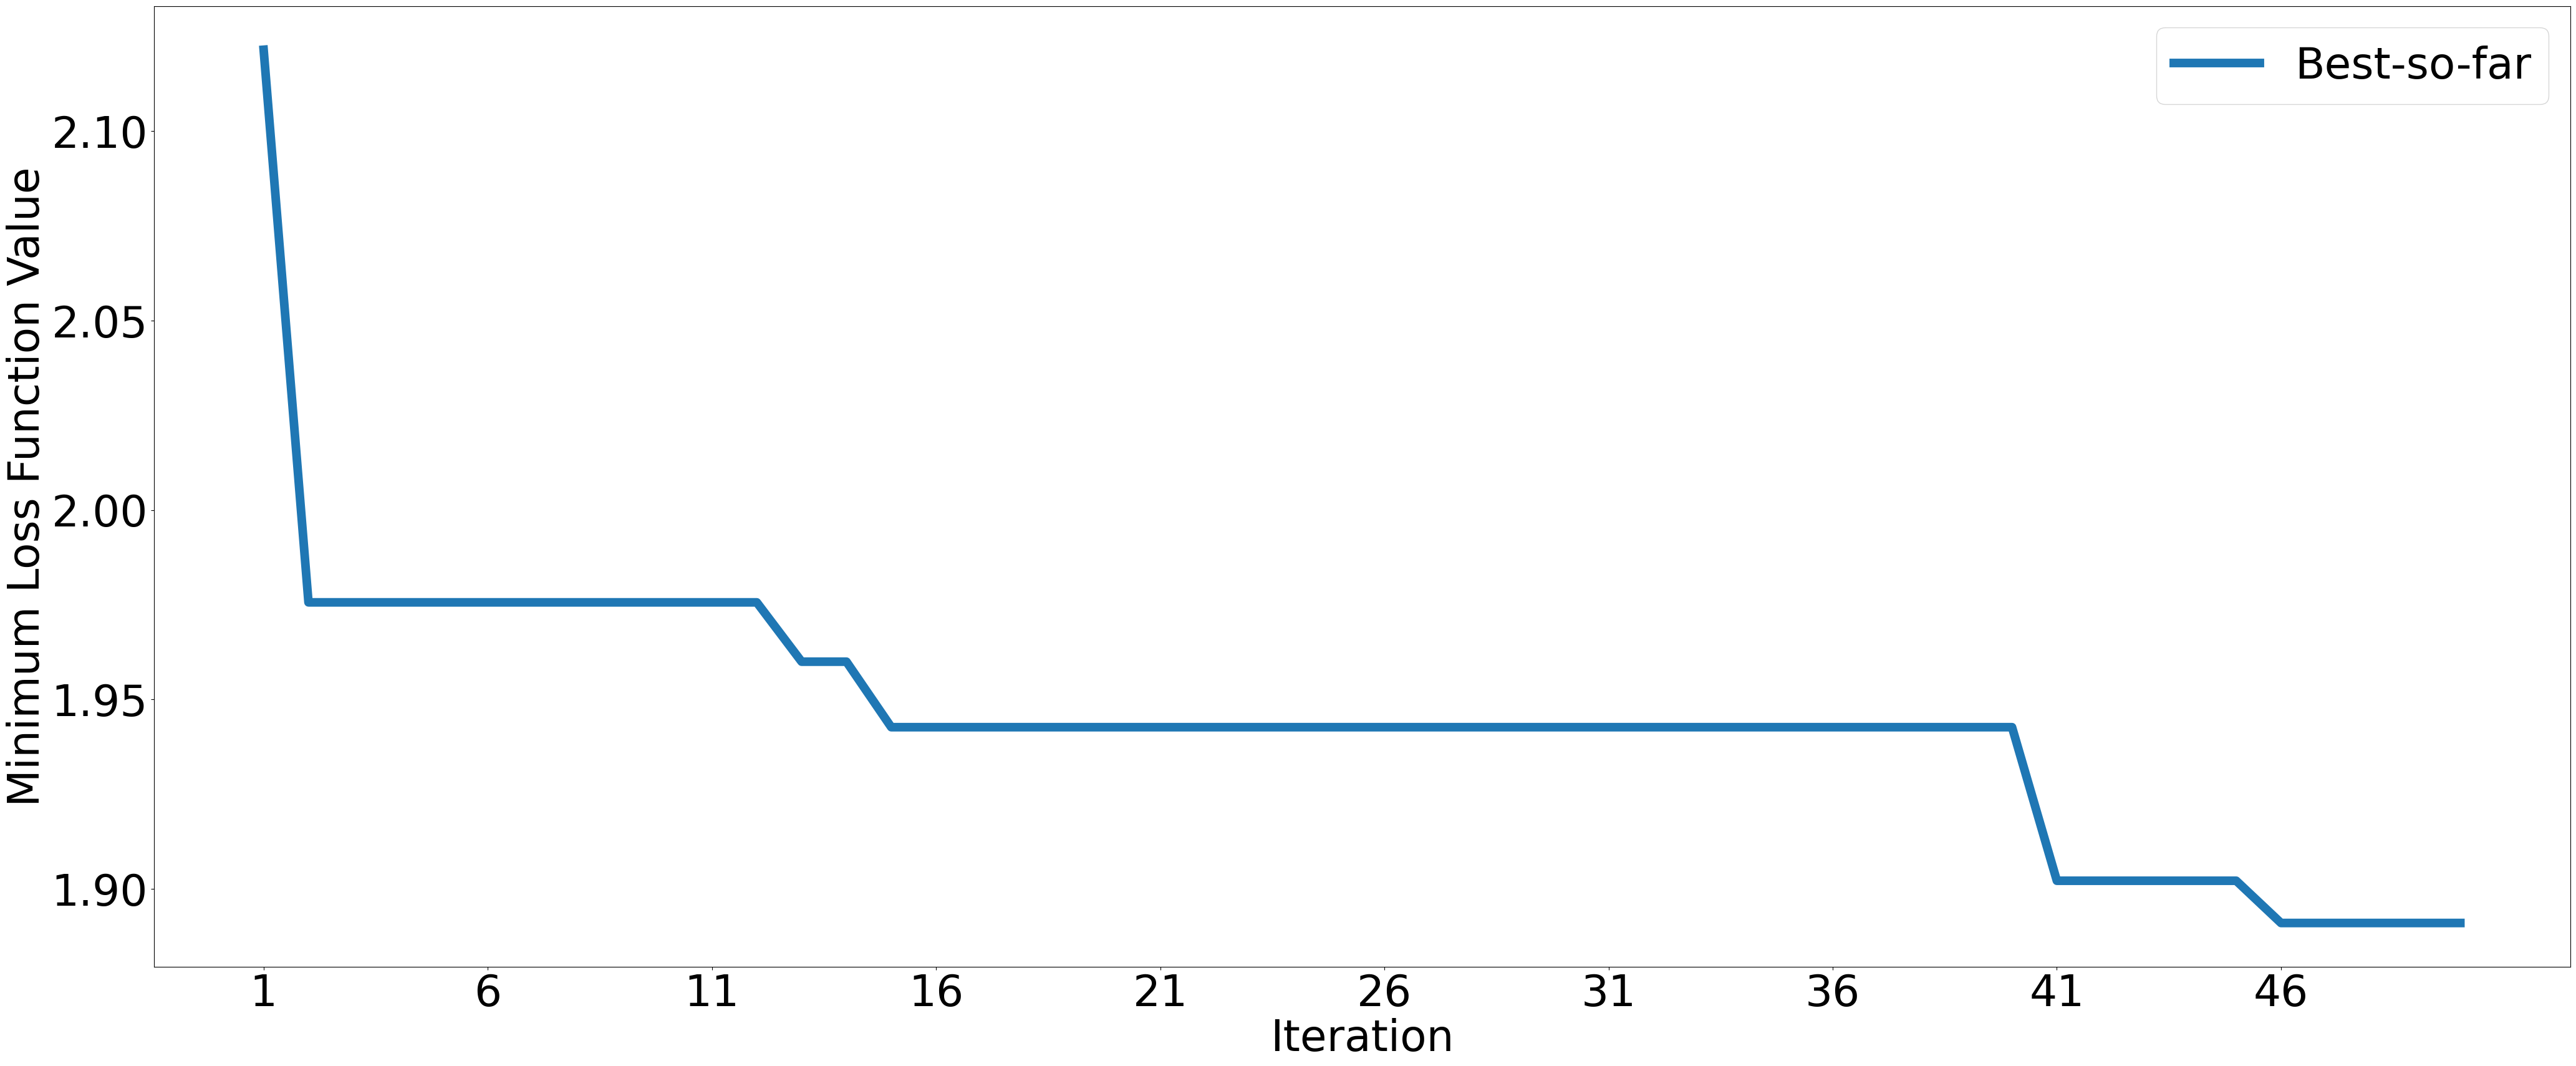

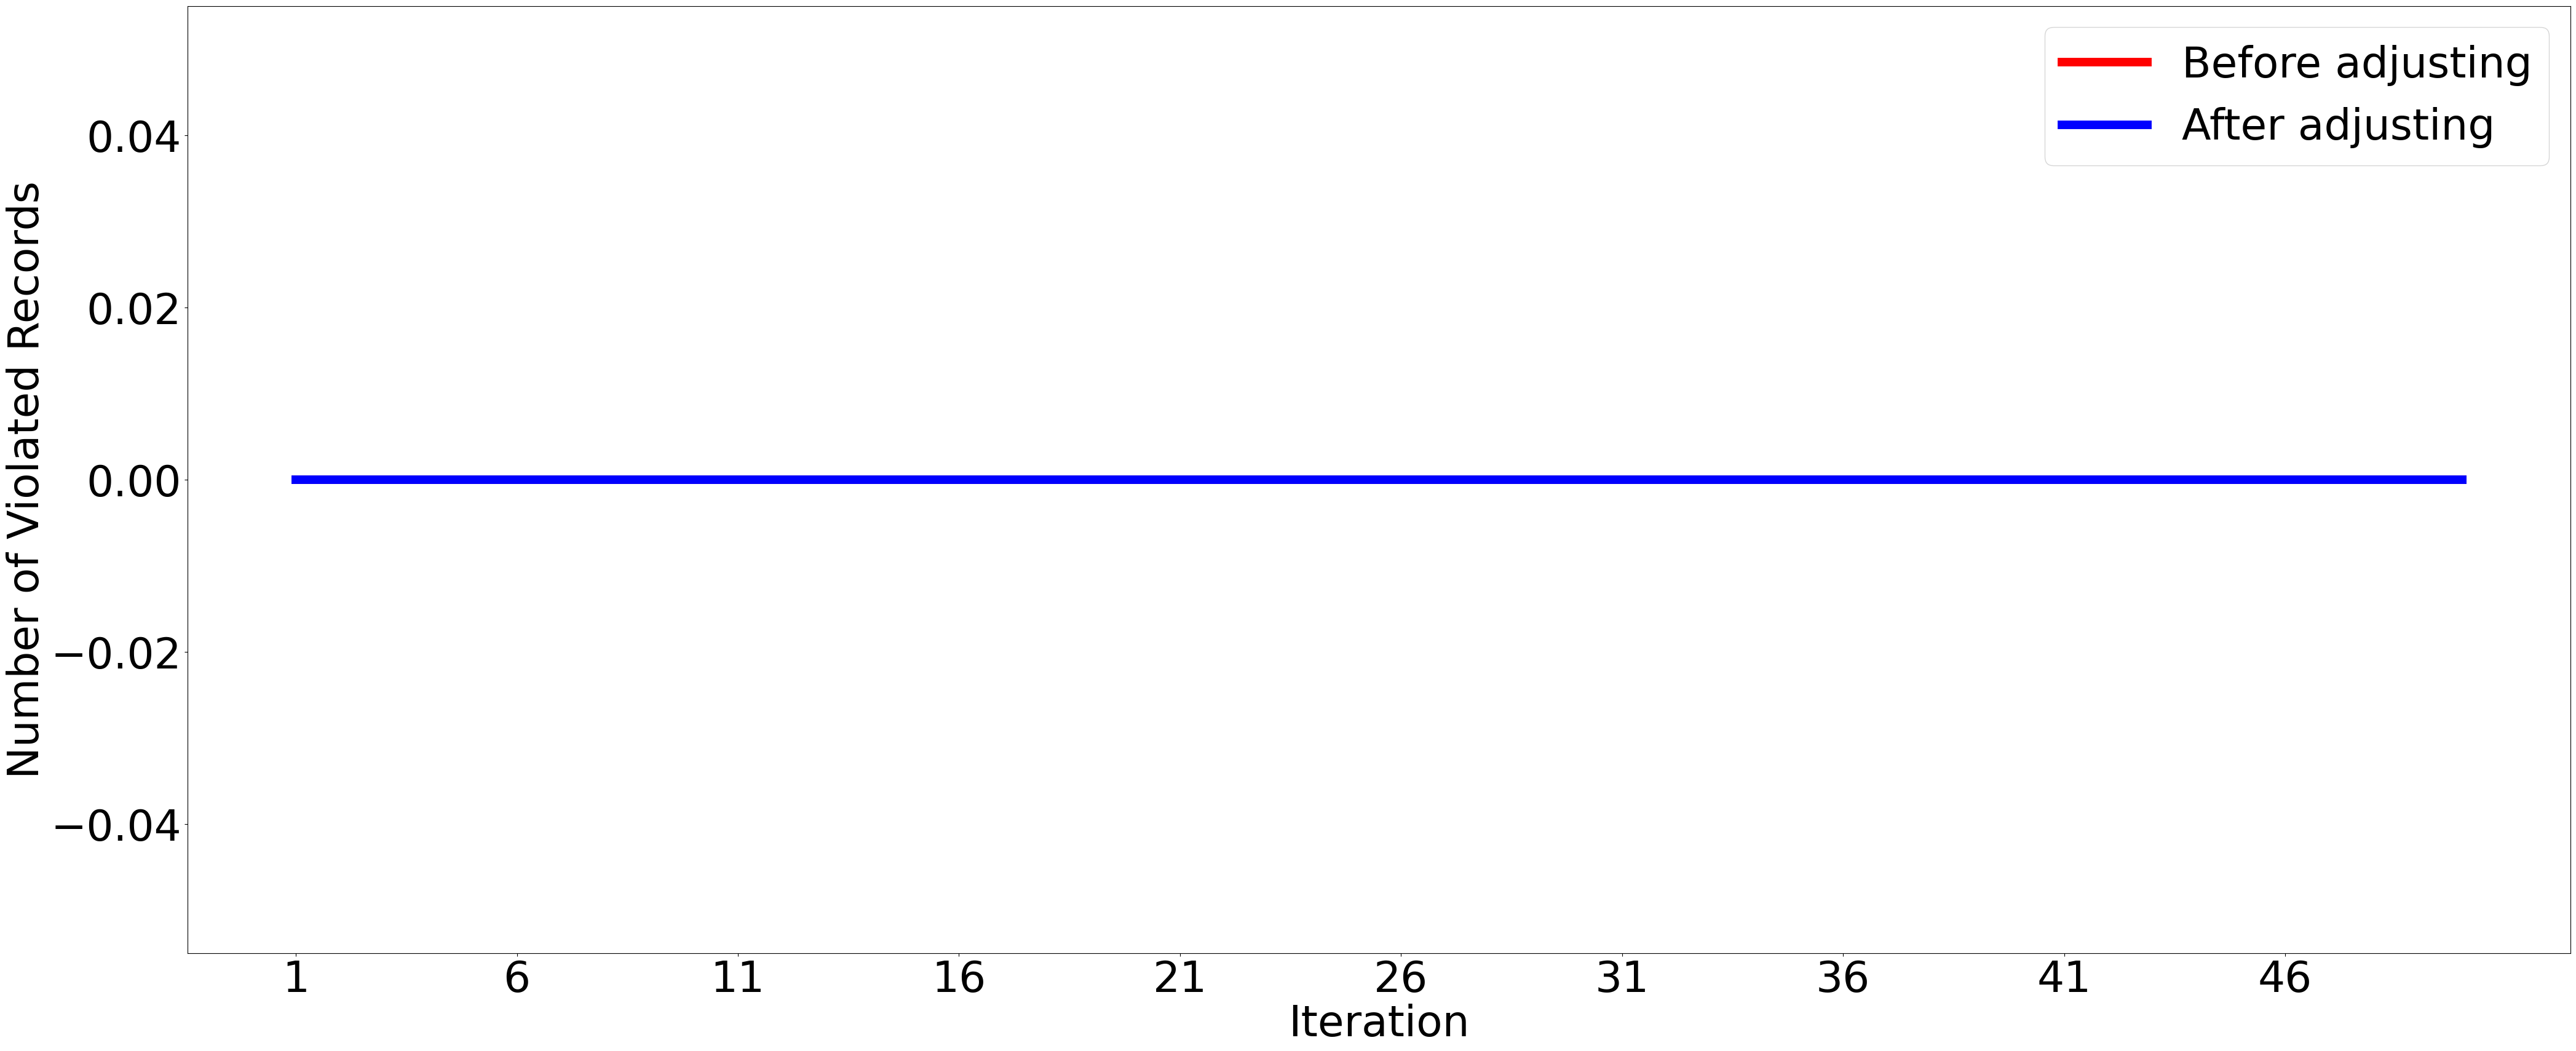

k: 20, n_cluster: 20, ML model: DT


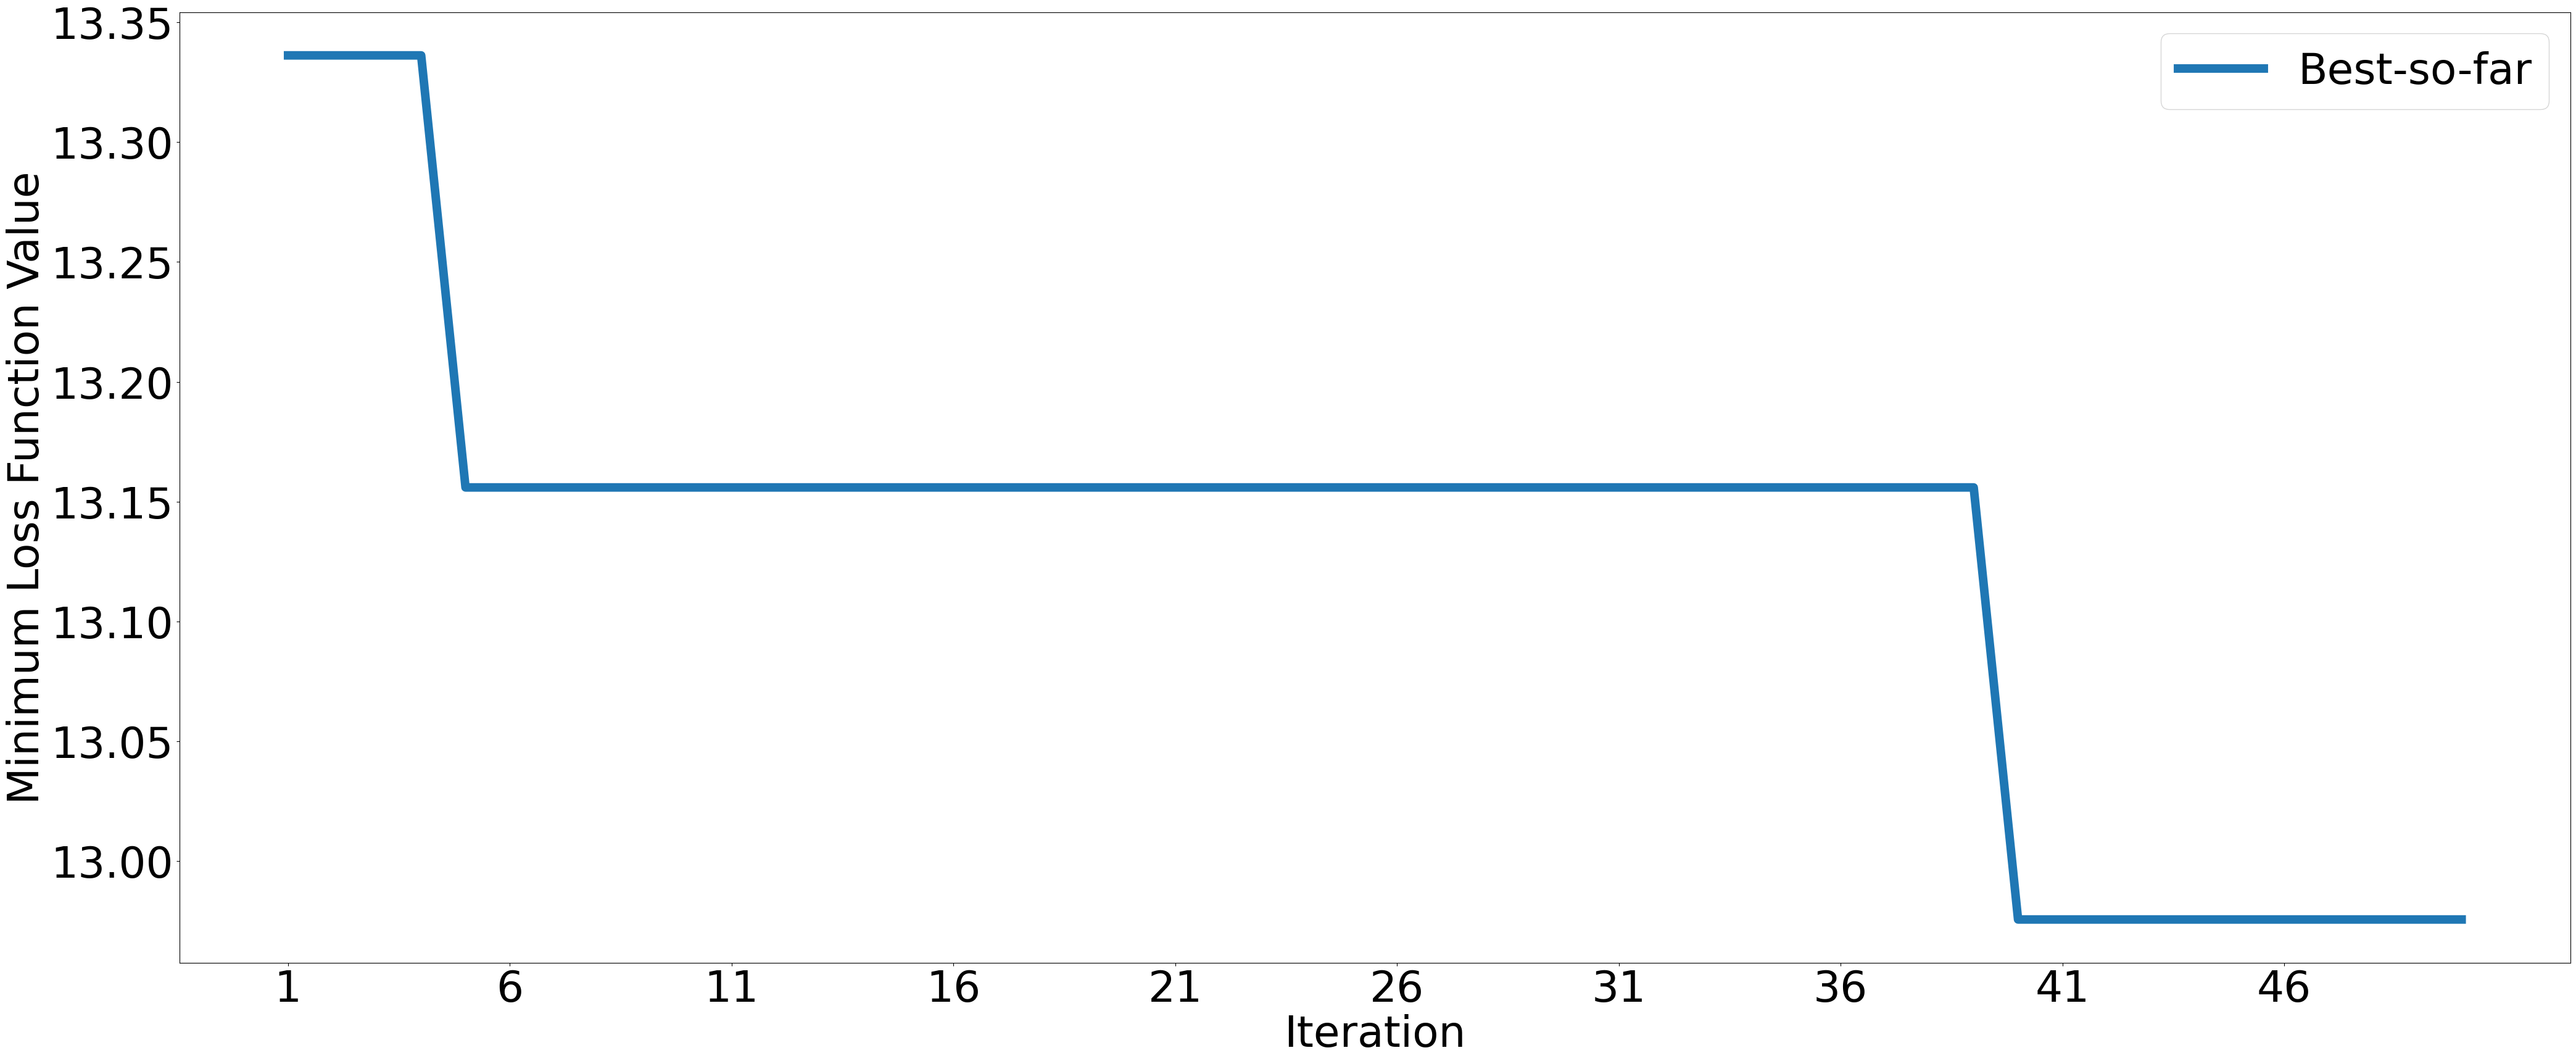

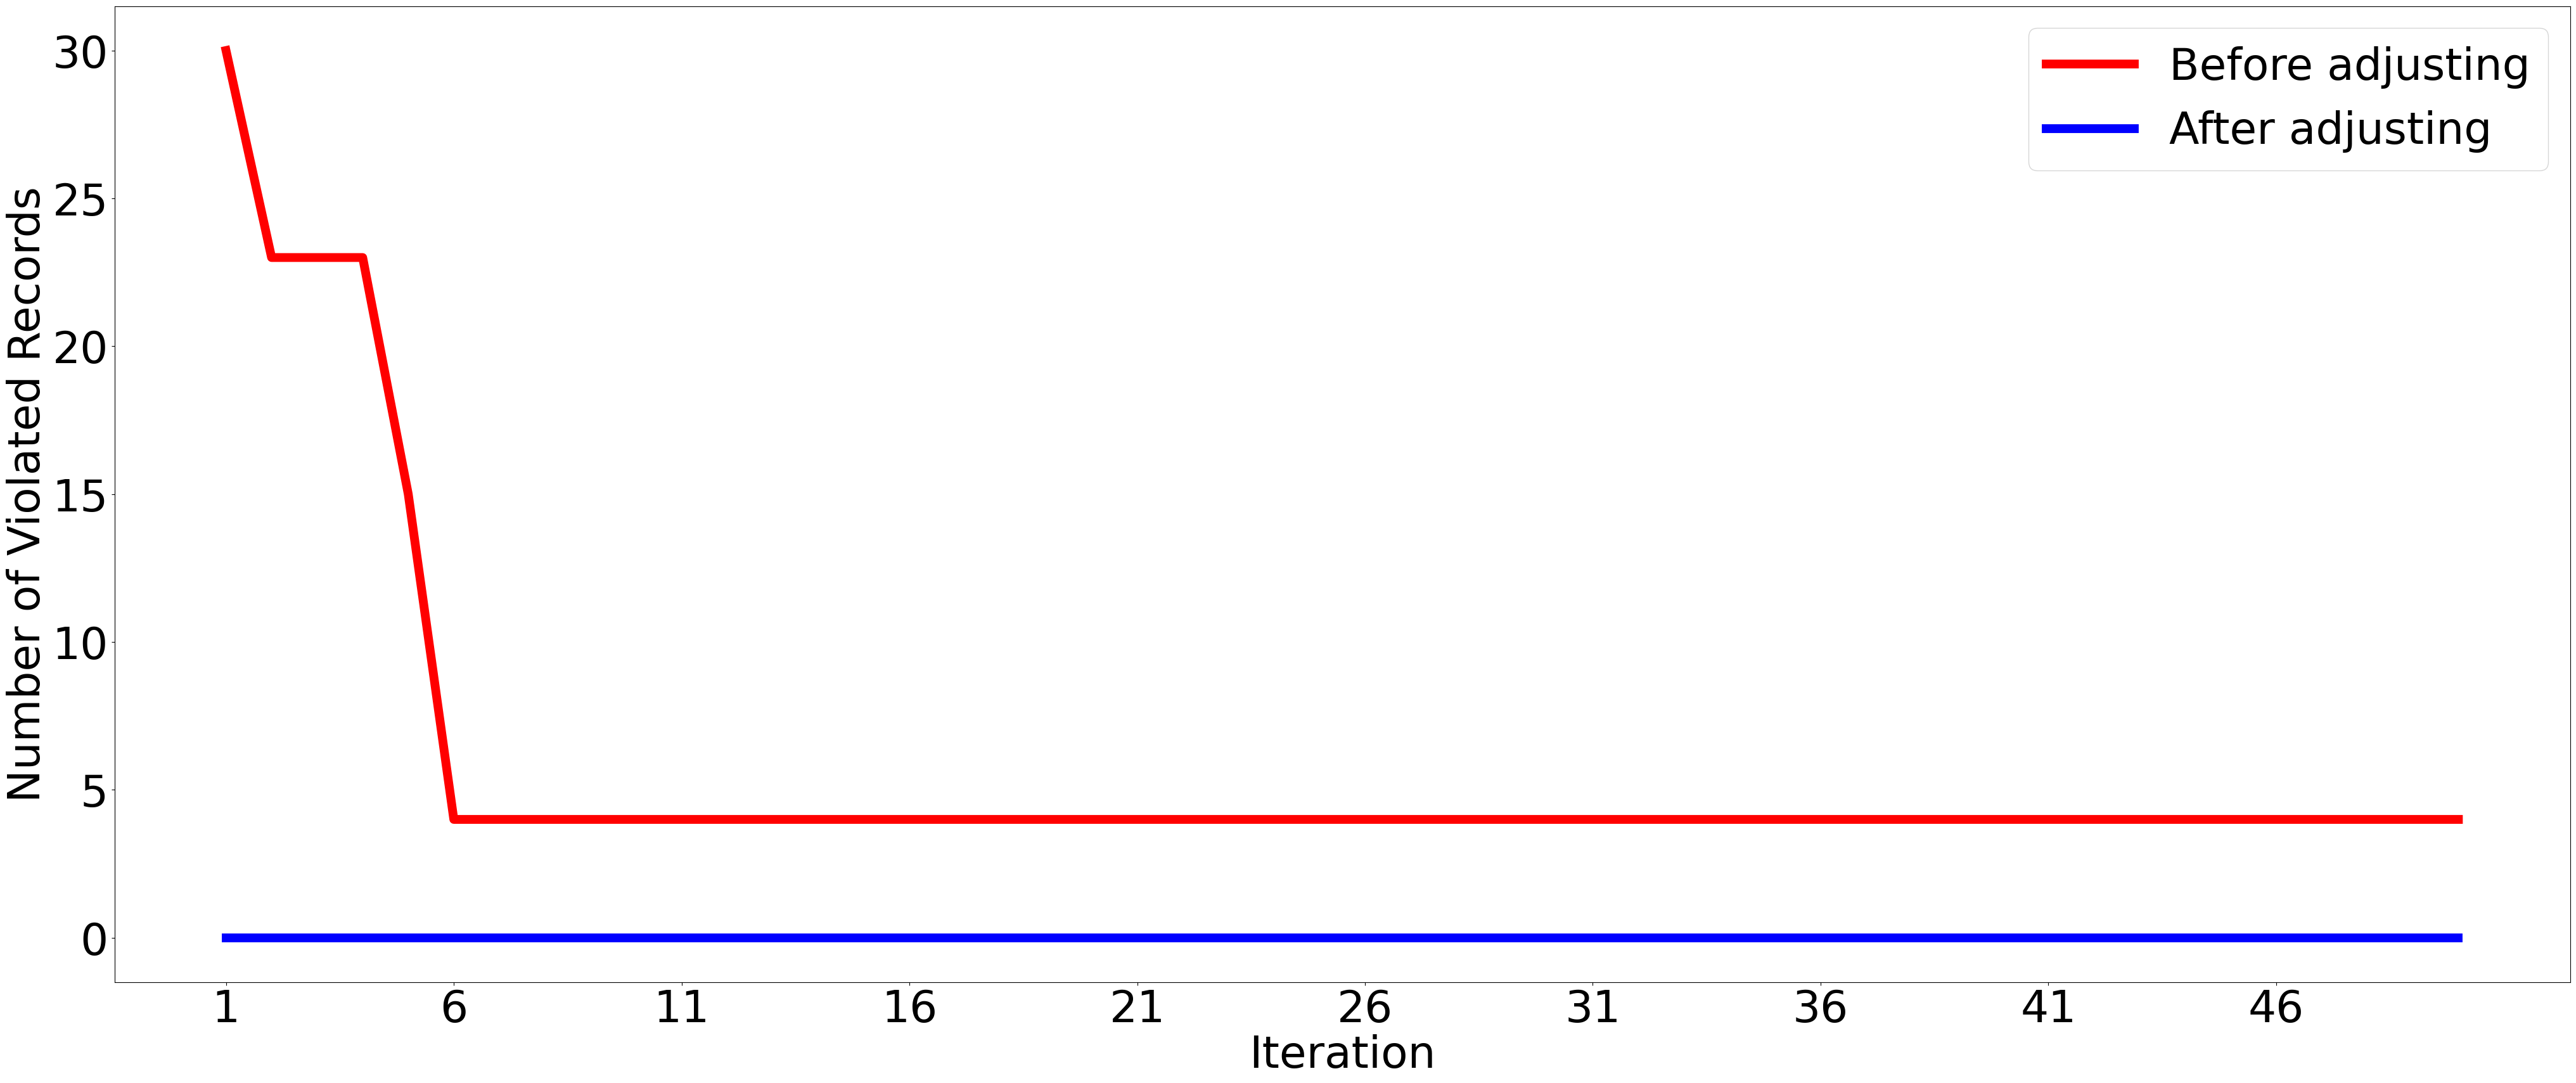

k: 20, n_cluster: 2, ML model: DT


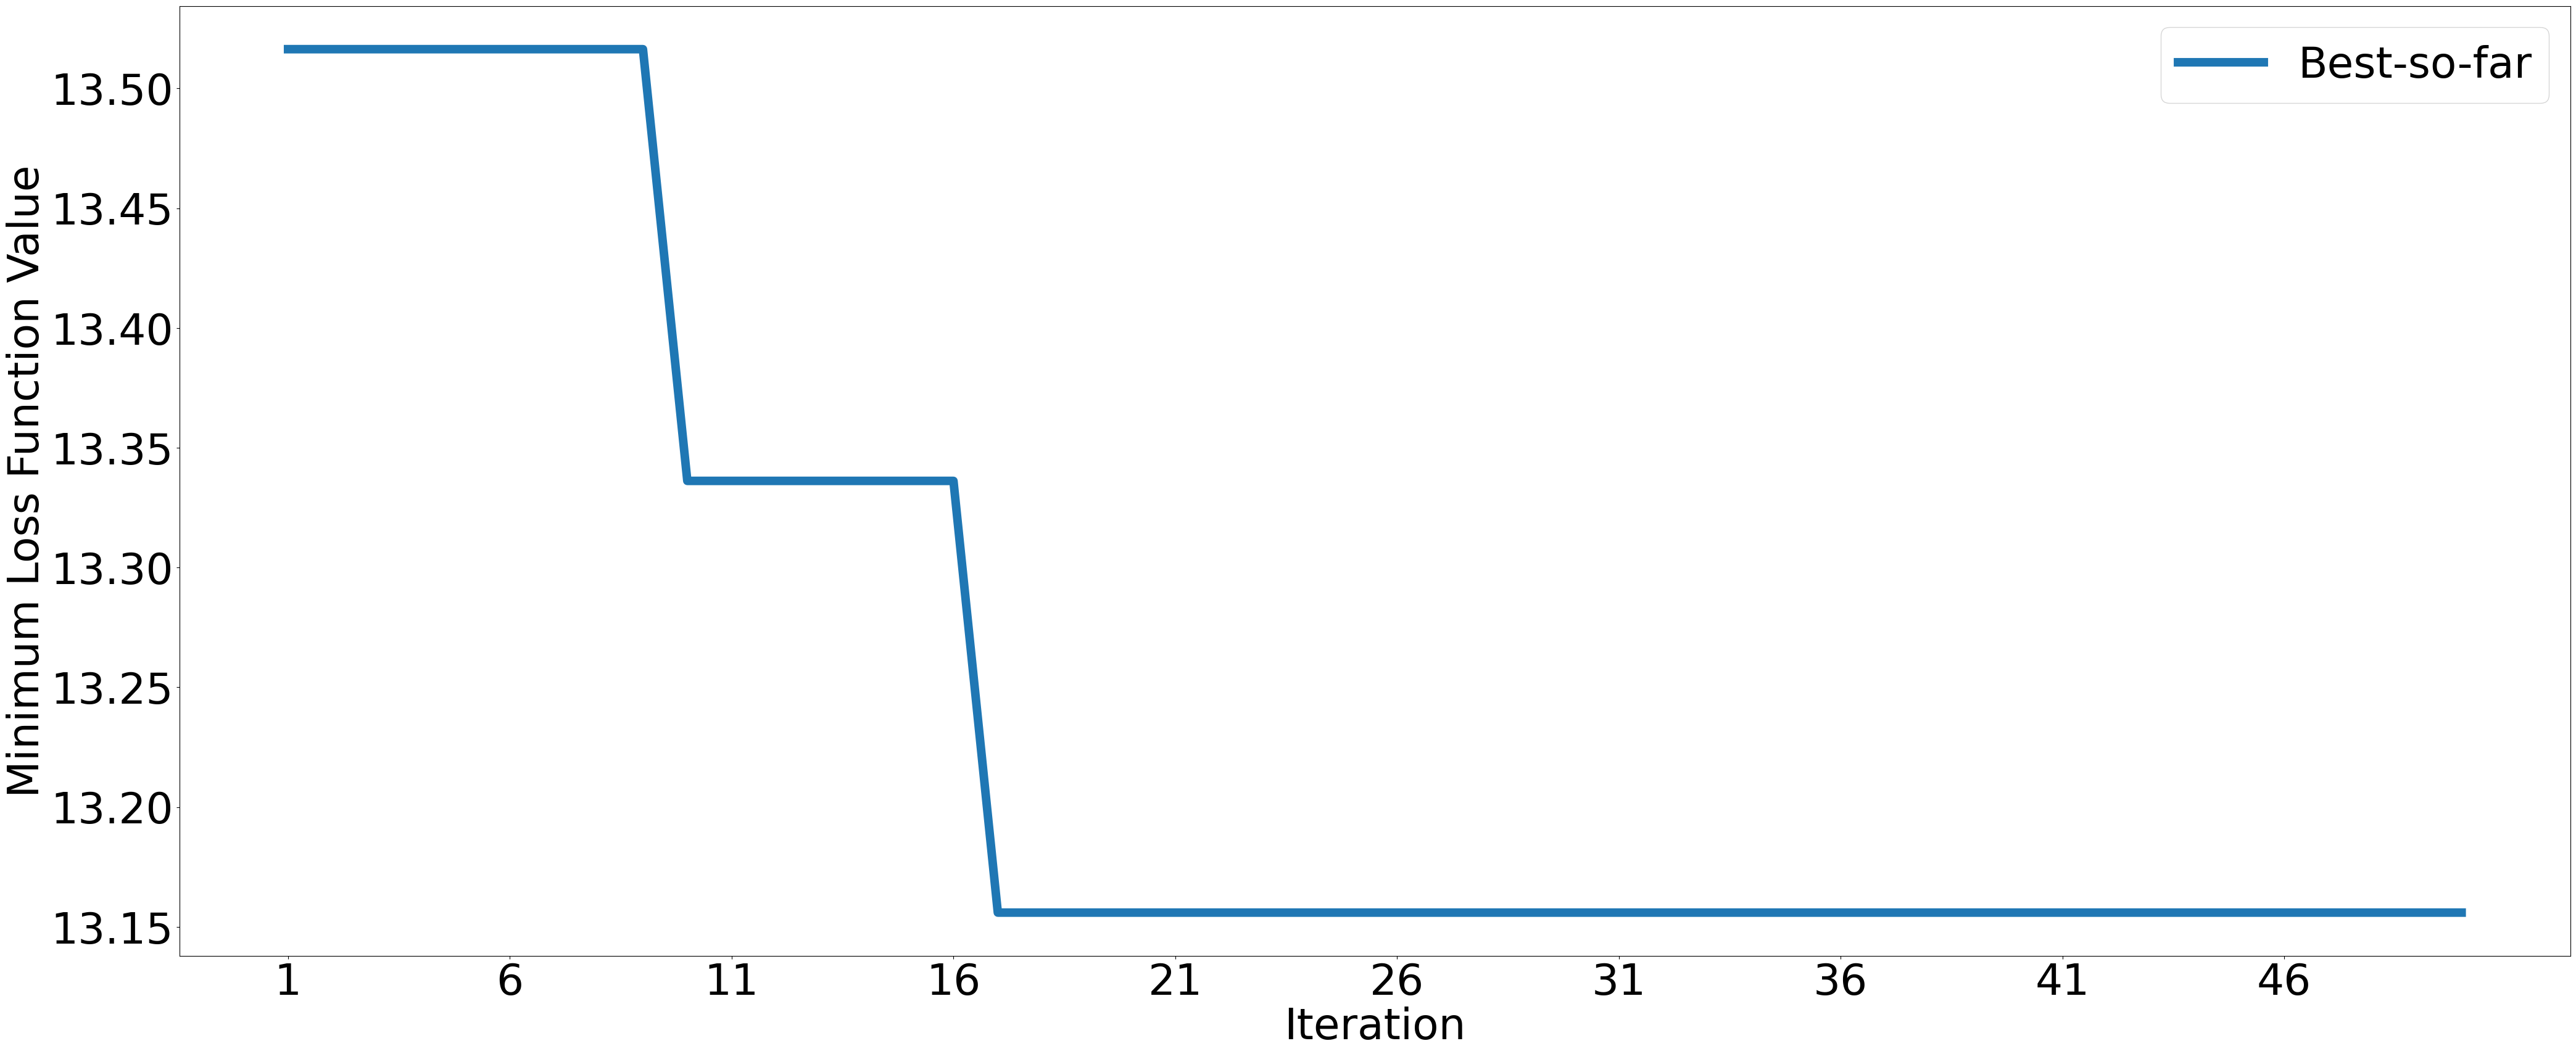

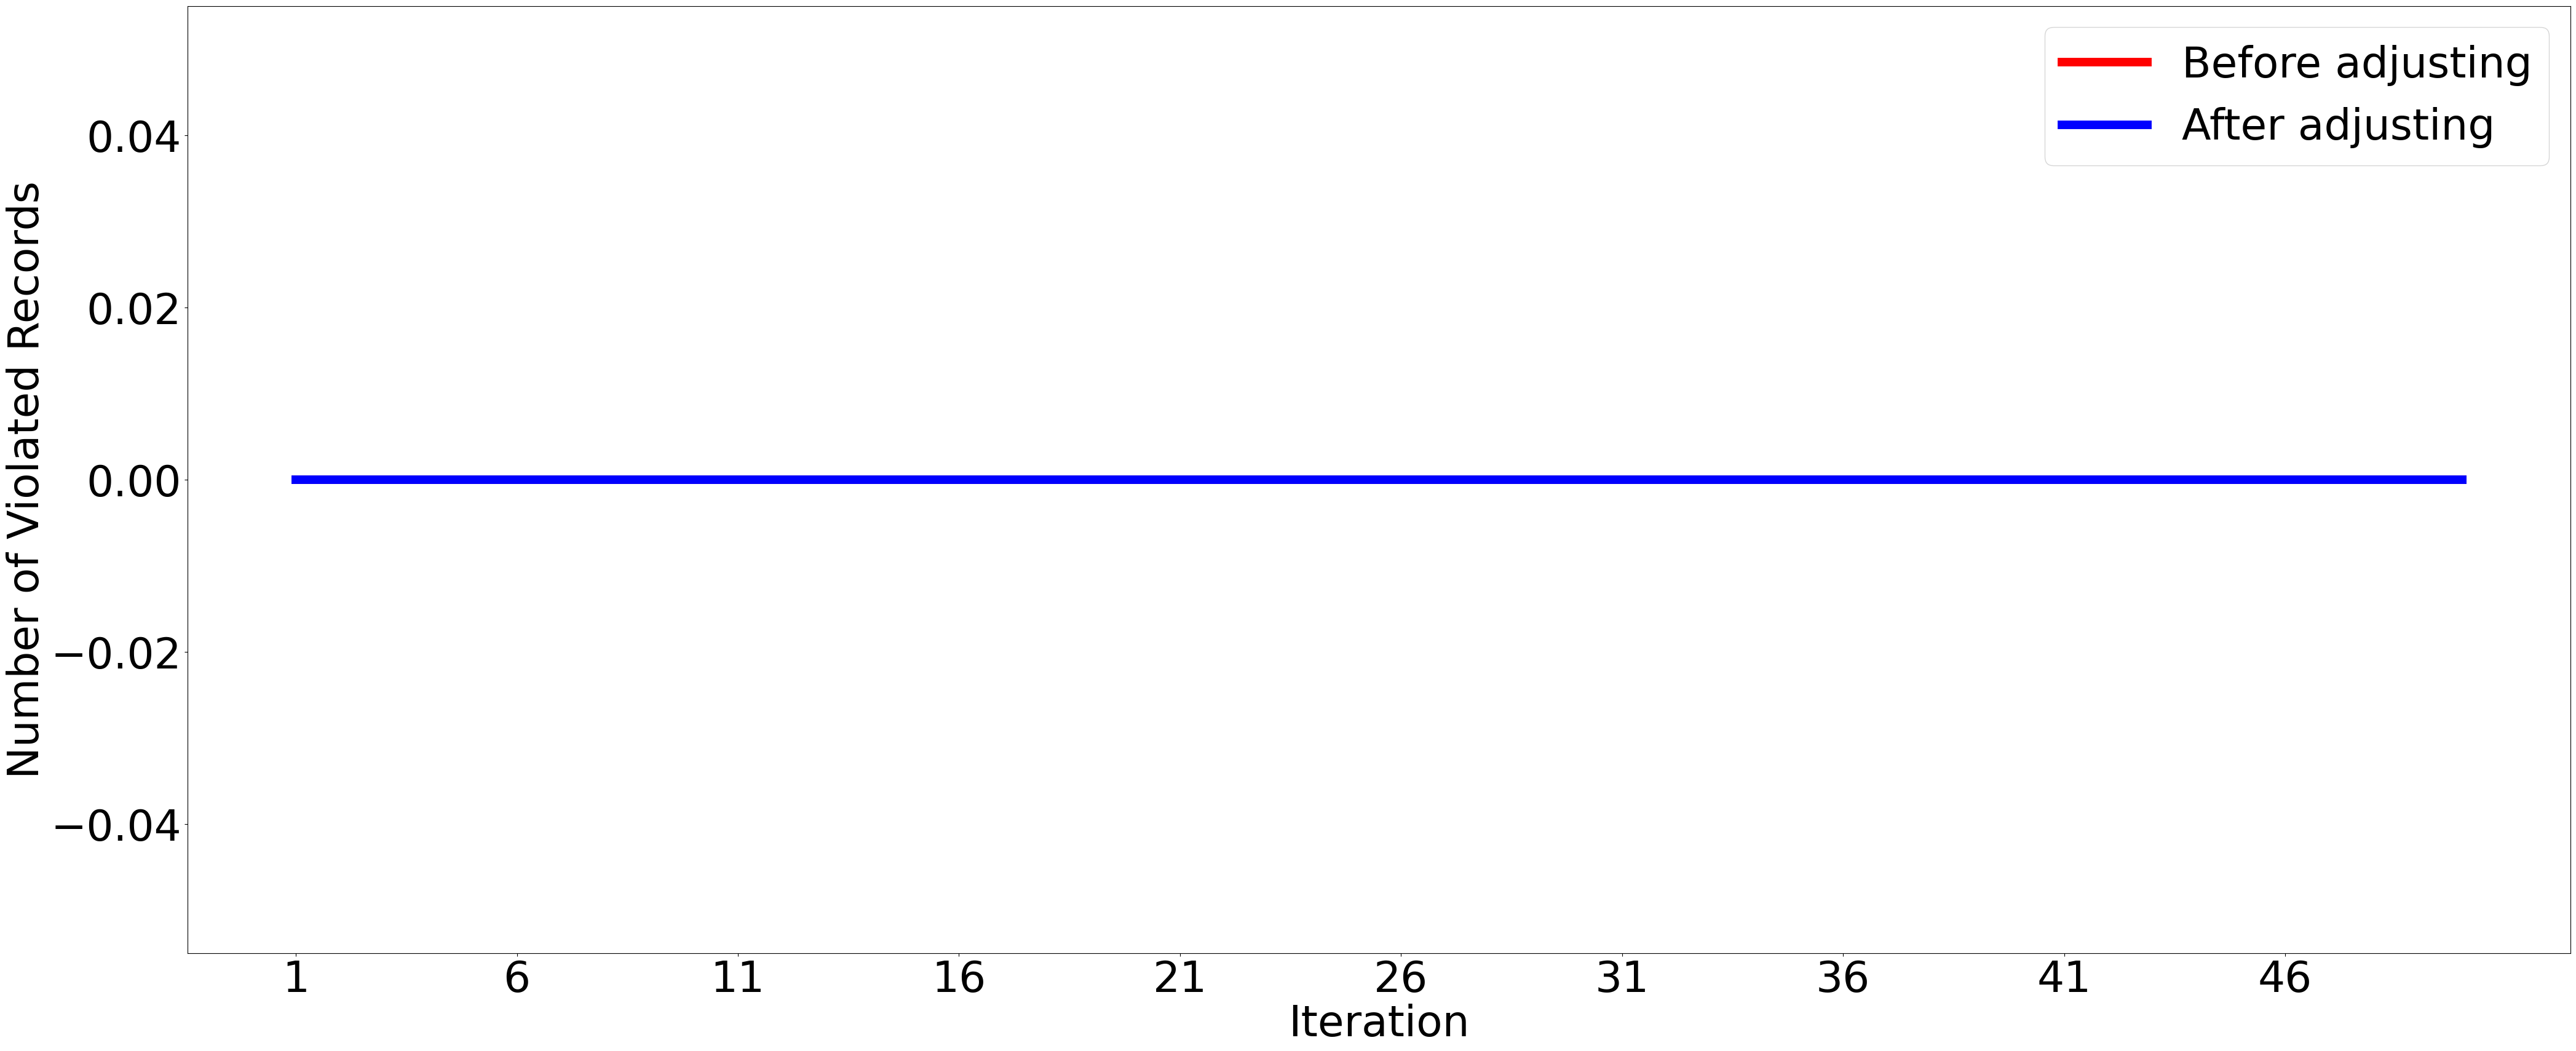

k: 20, n_cluster: 40, ML model: NB


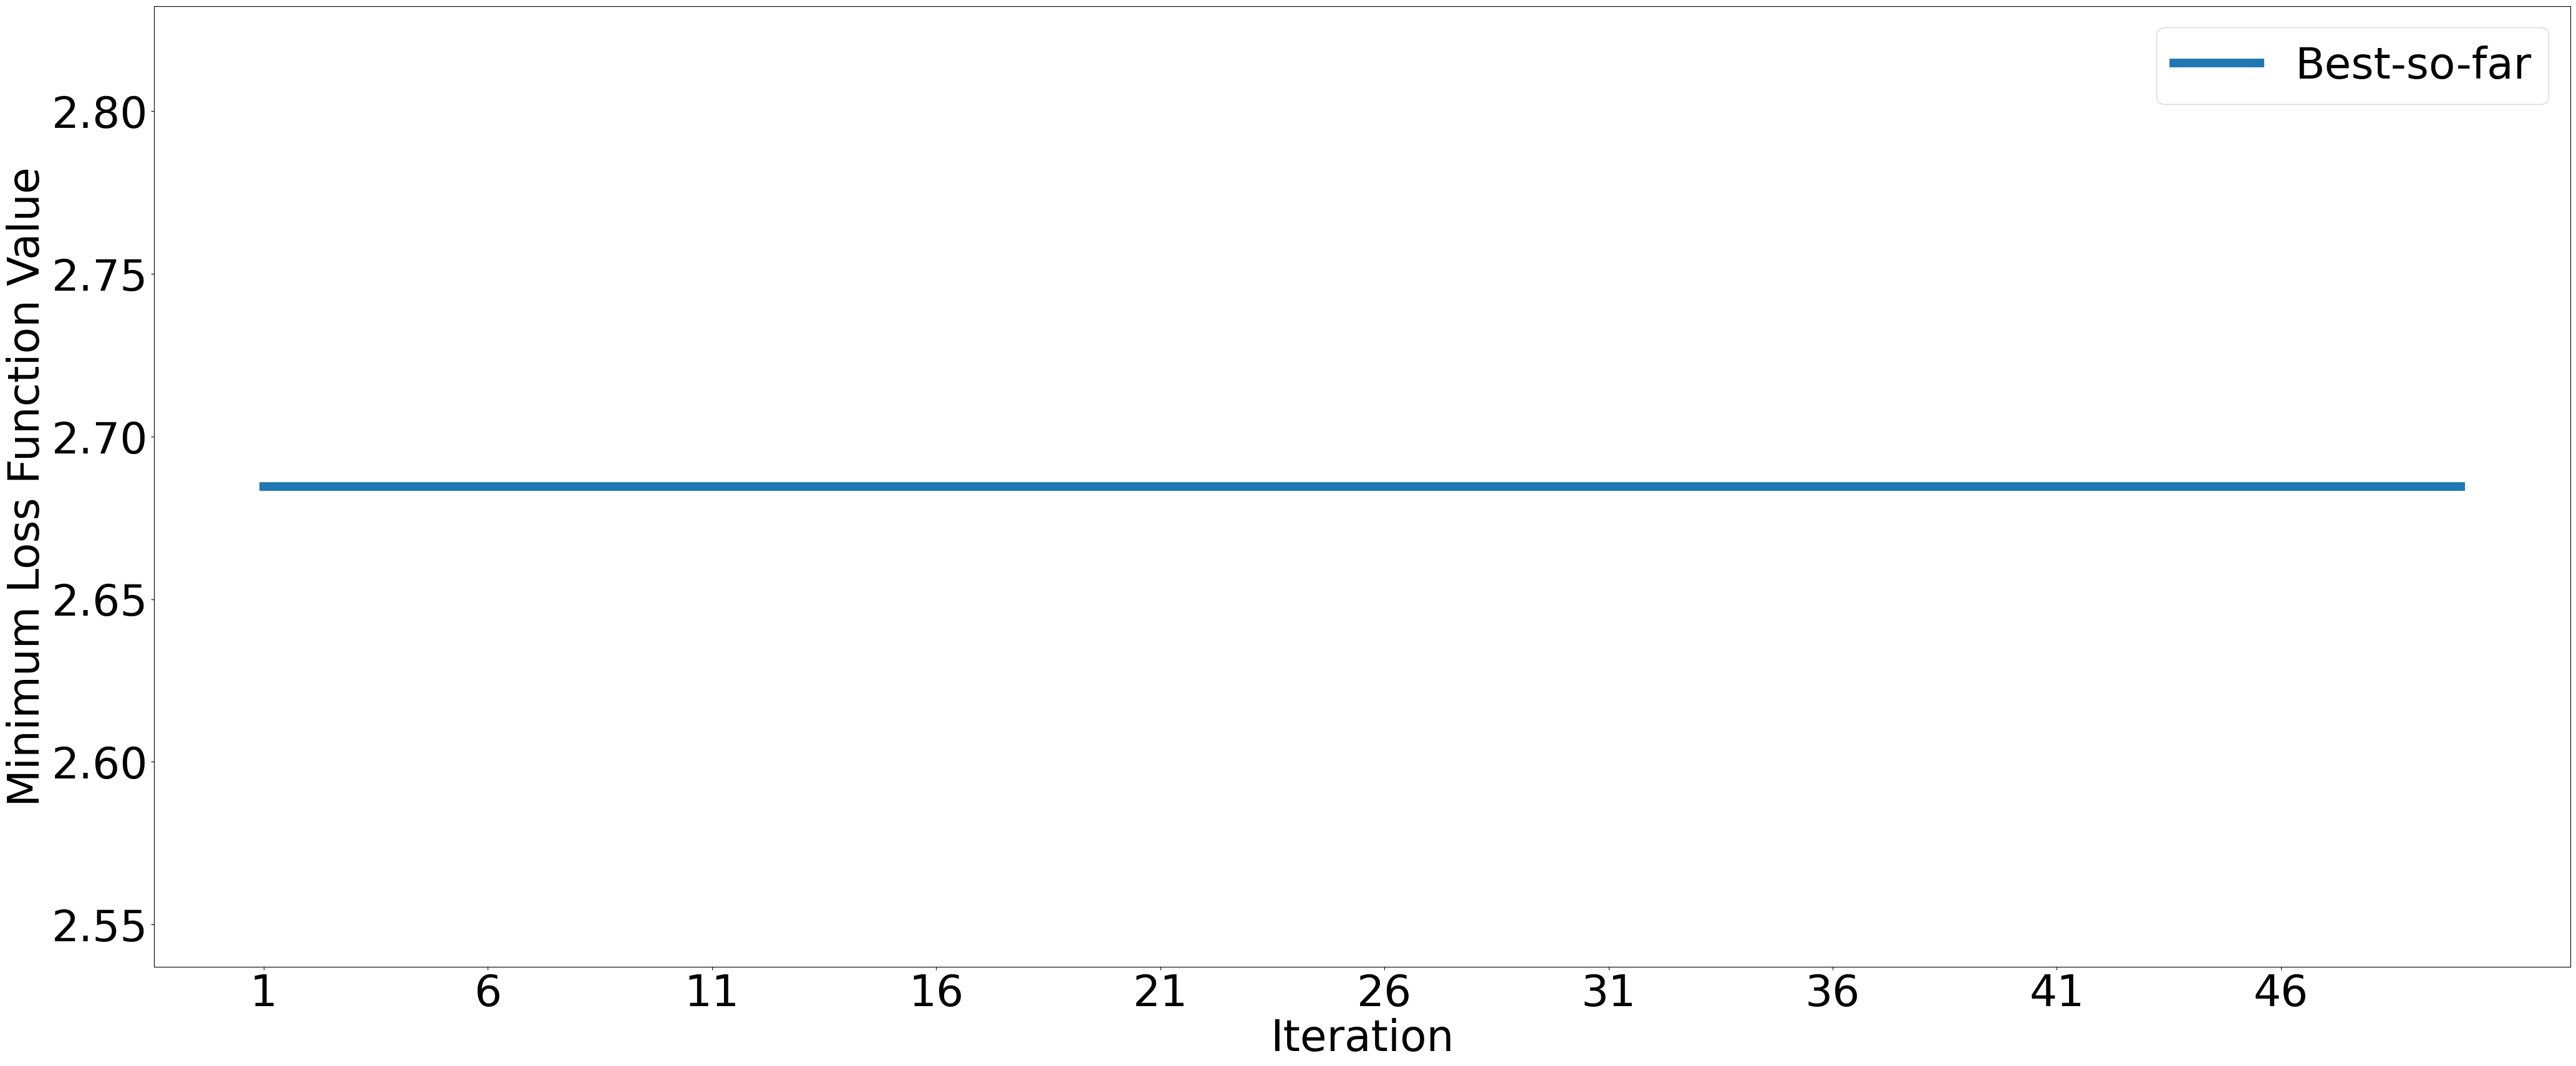

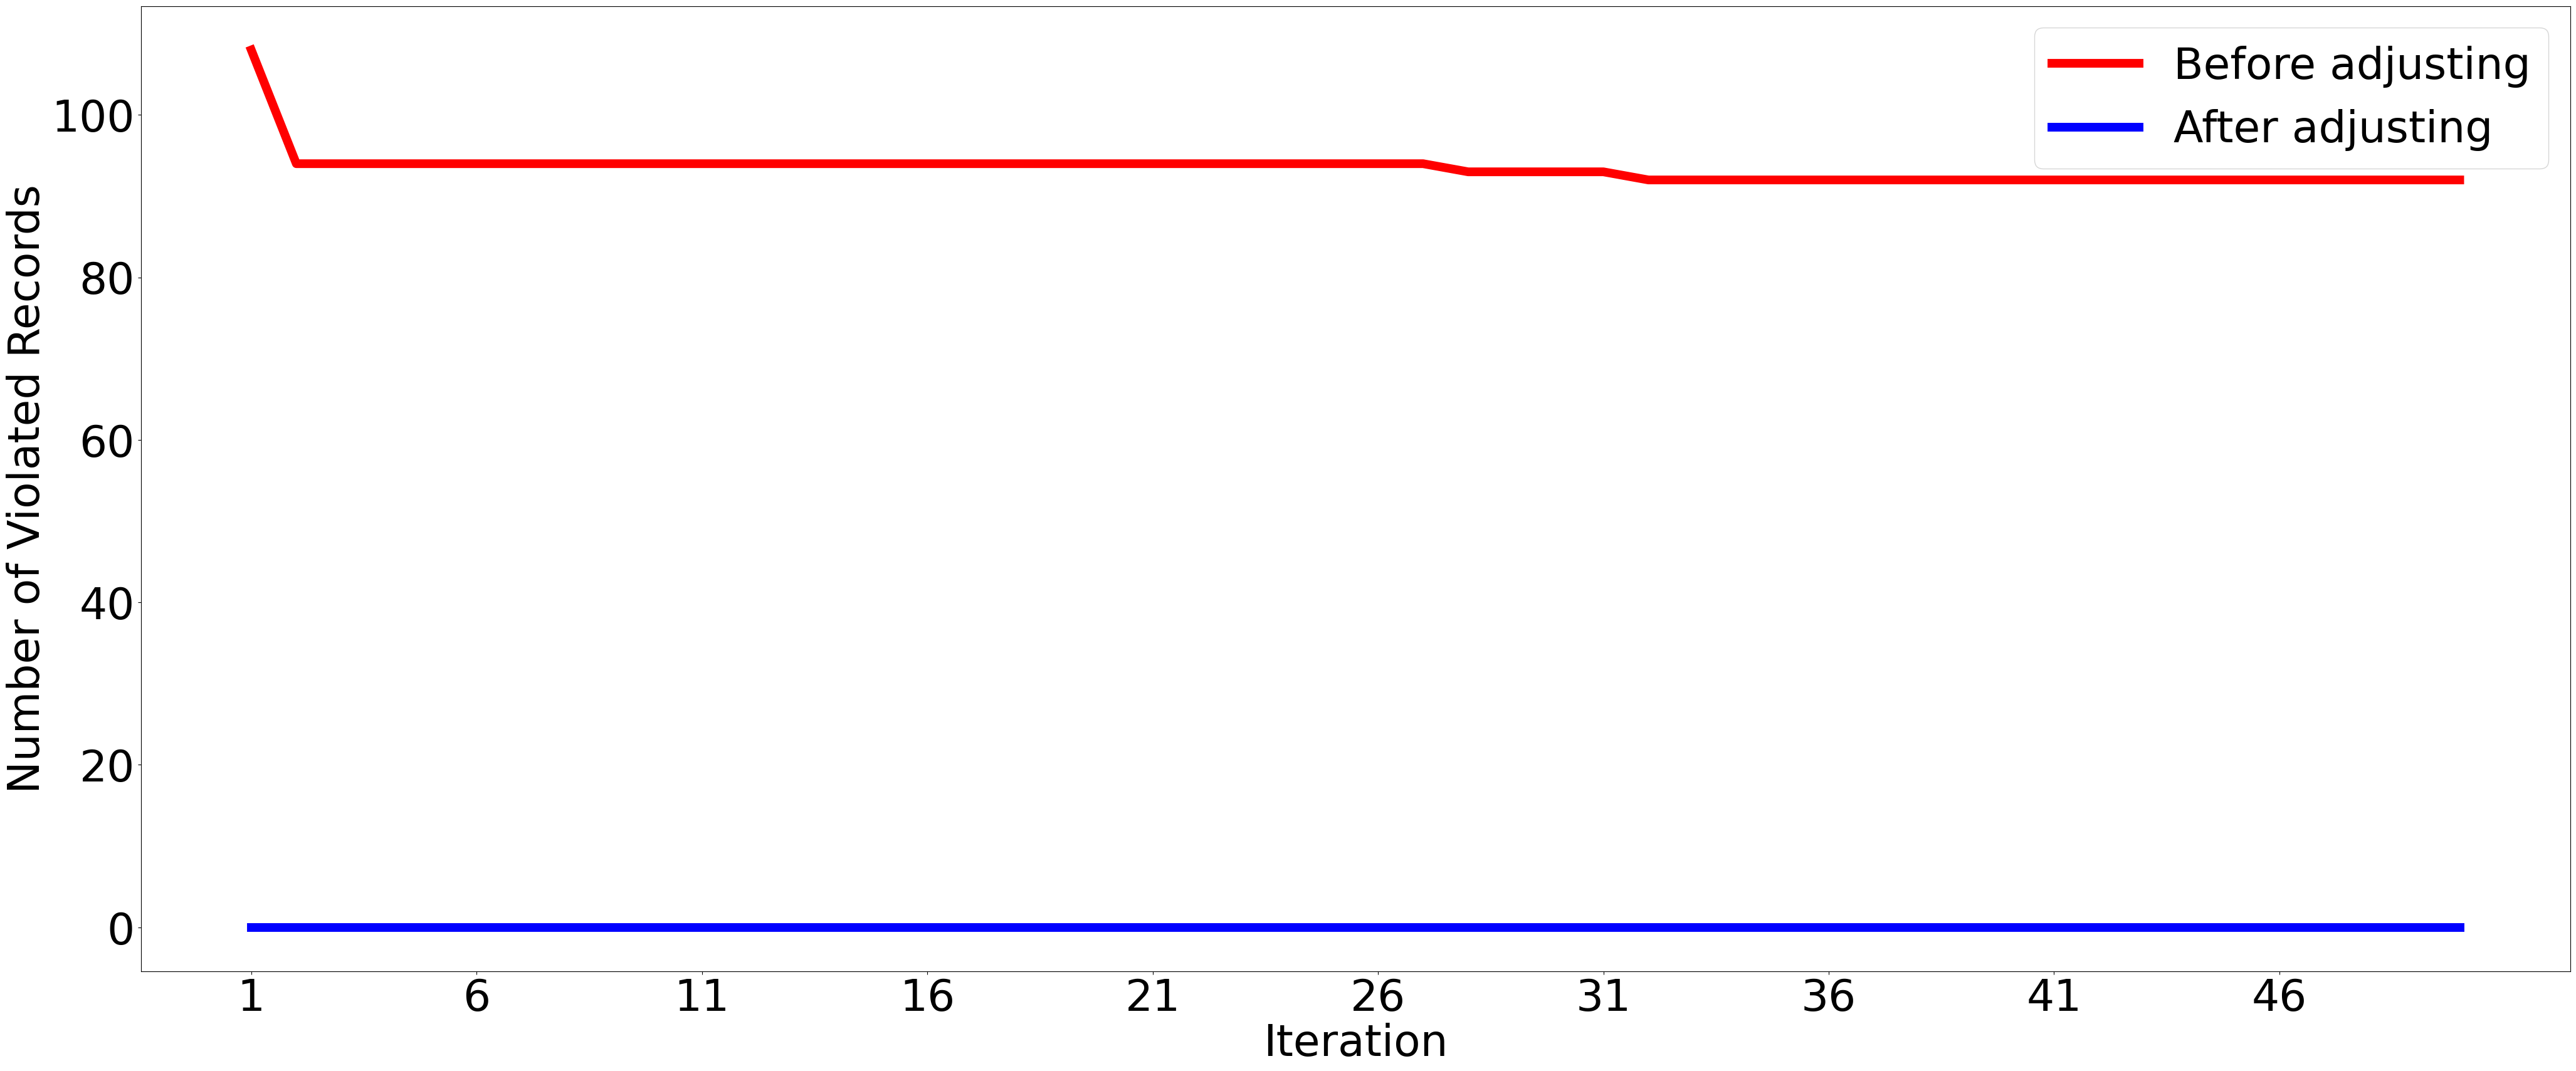

k: 20, n_cluster: 50, ML model: NB


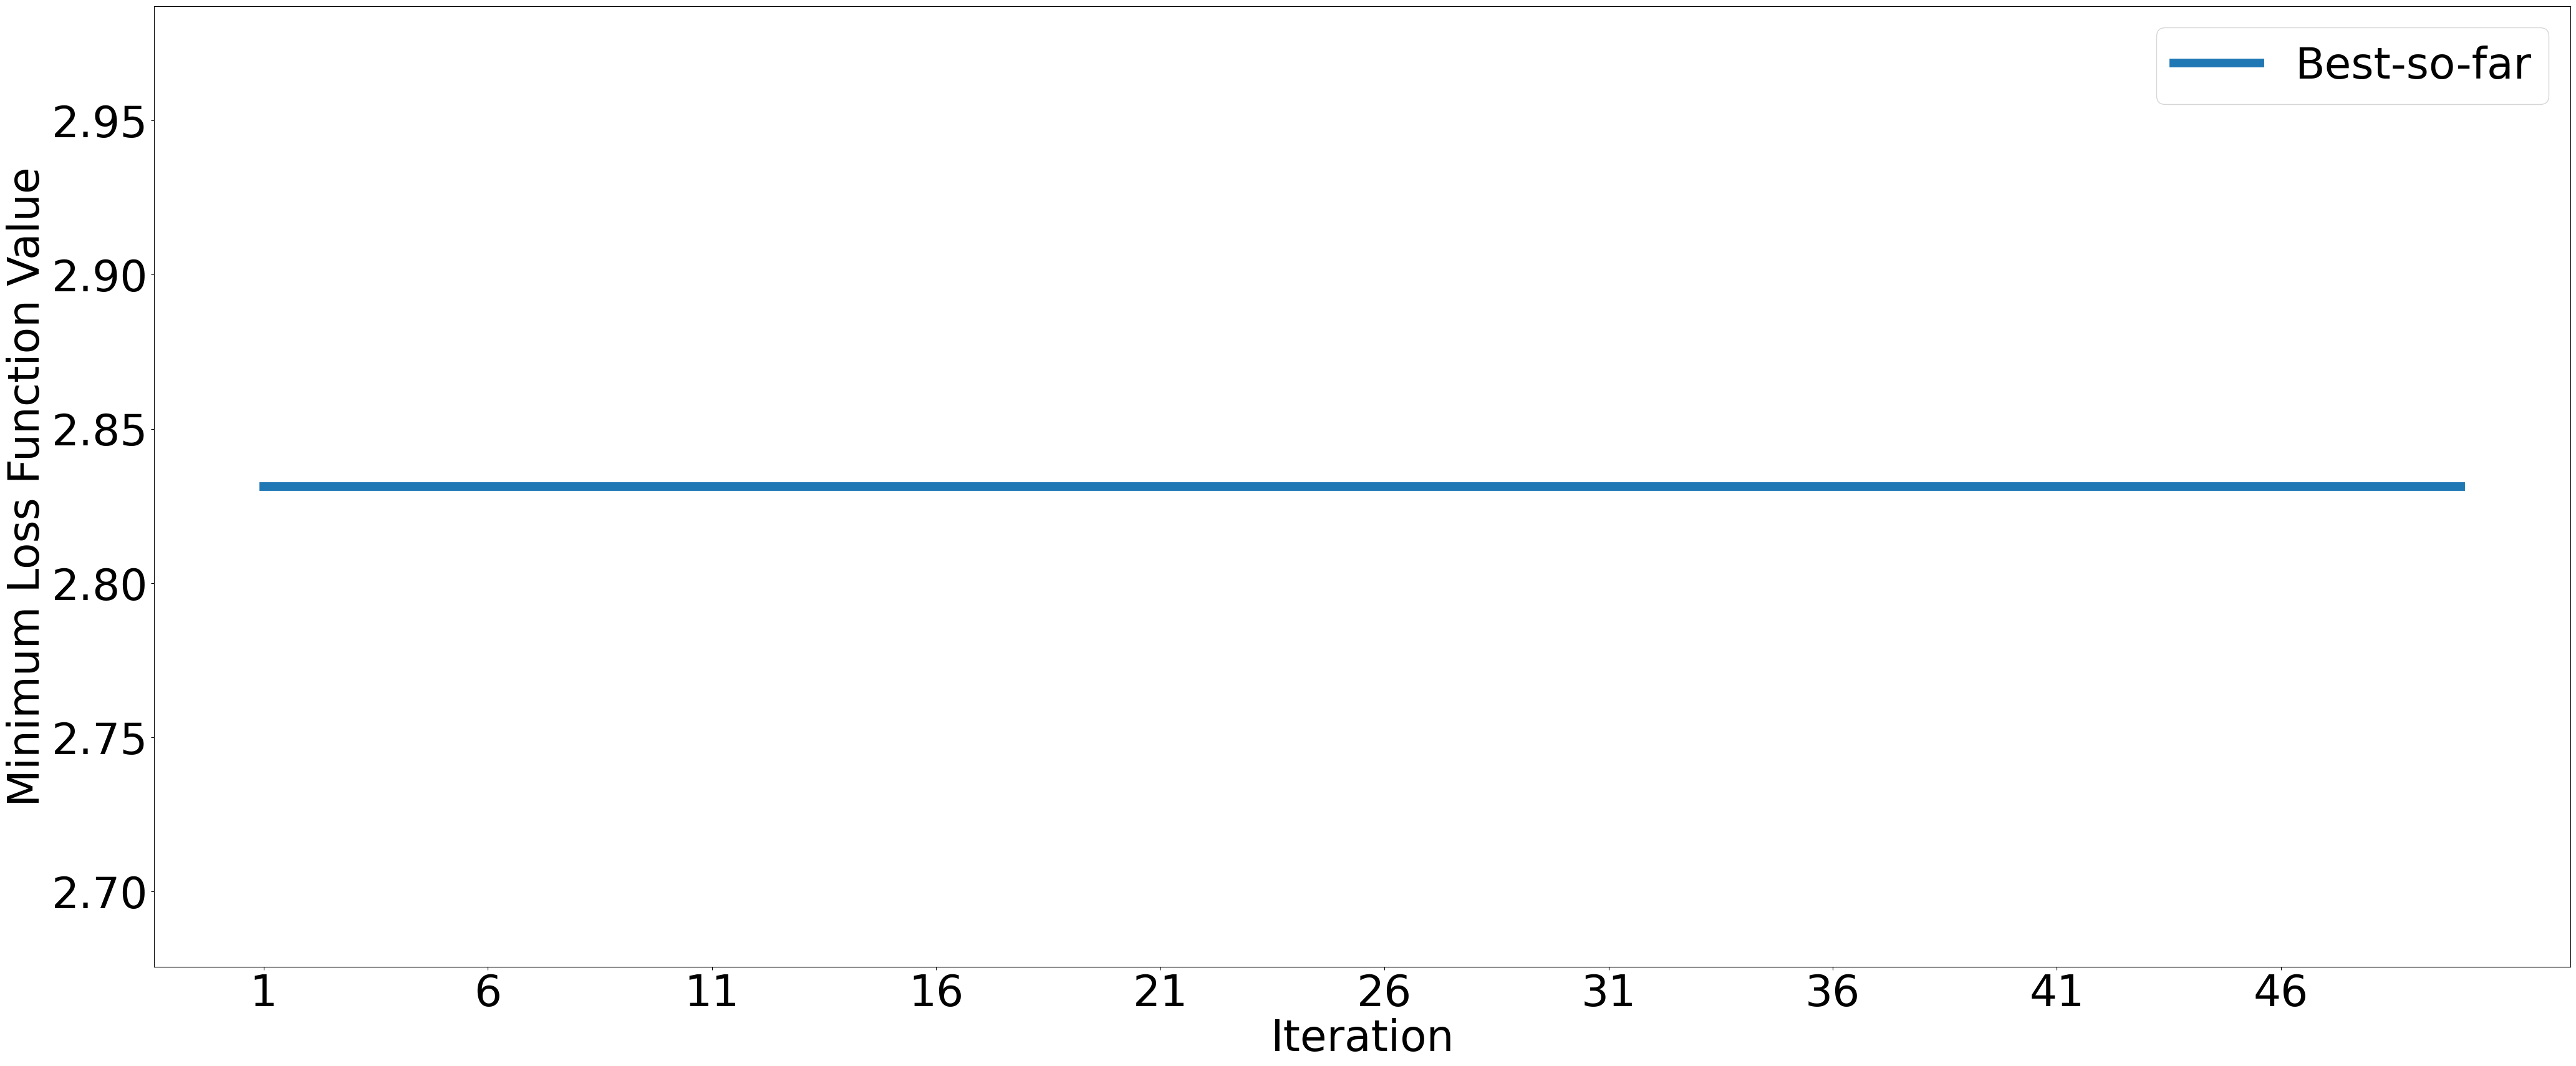

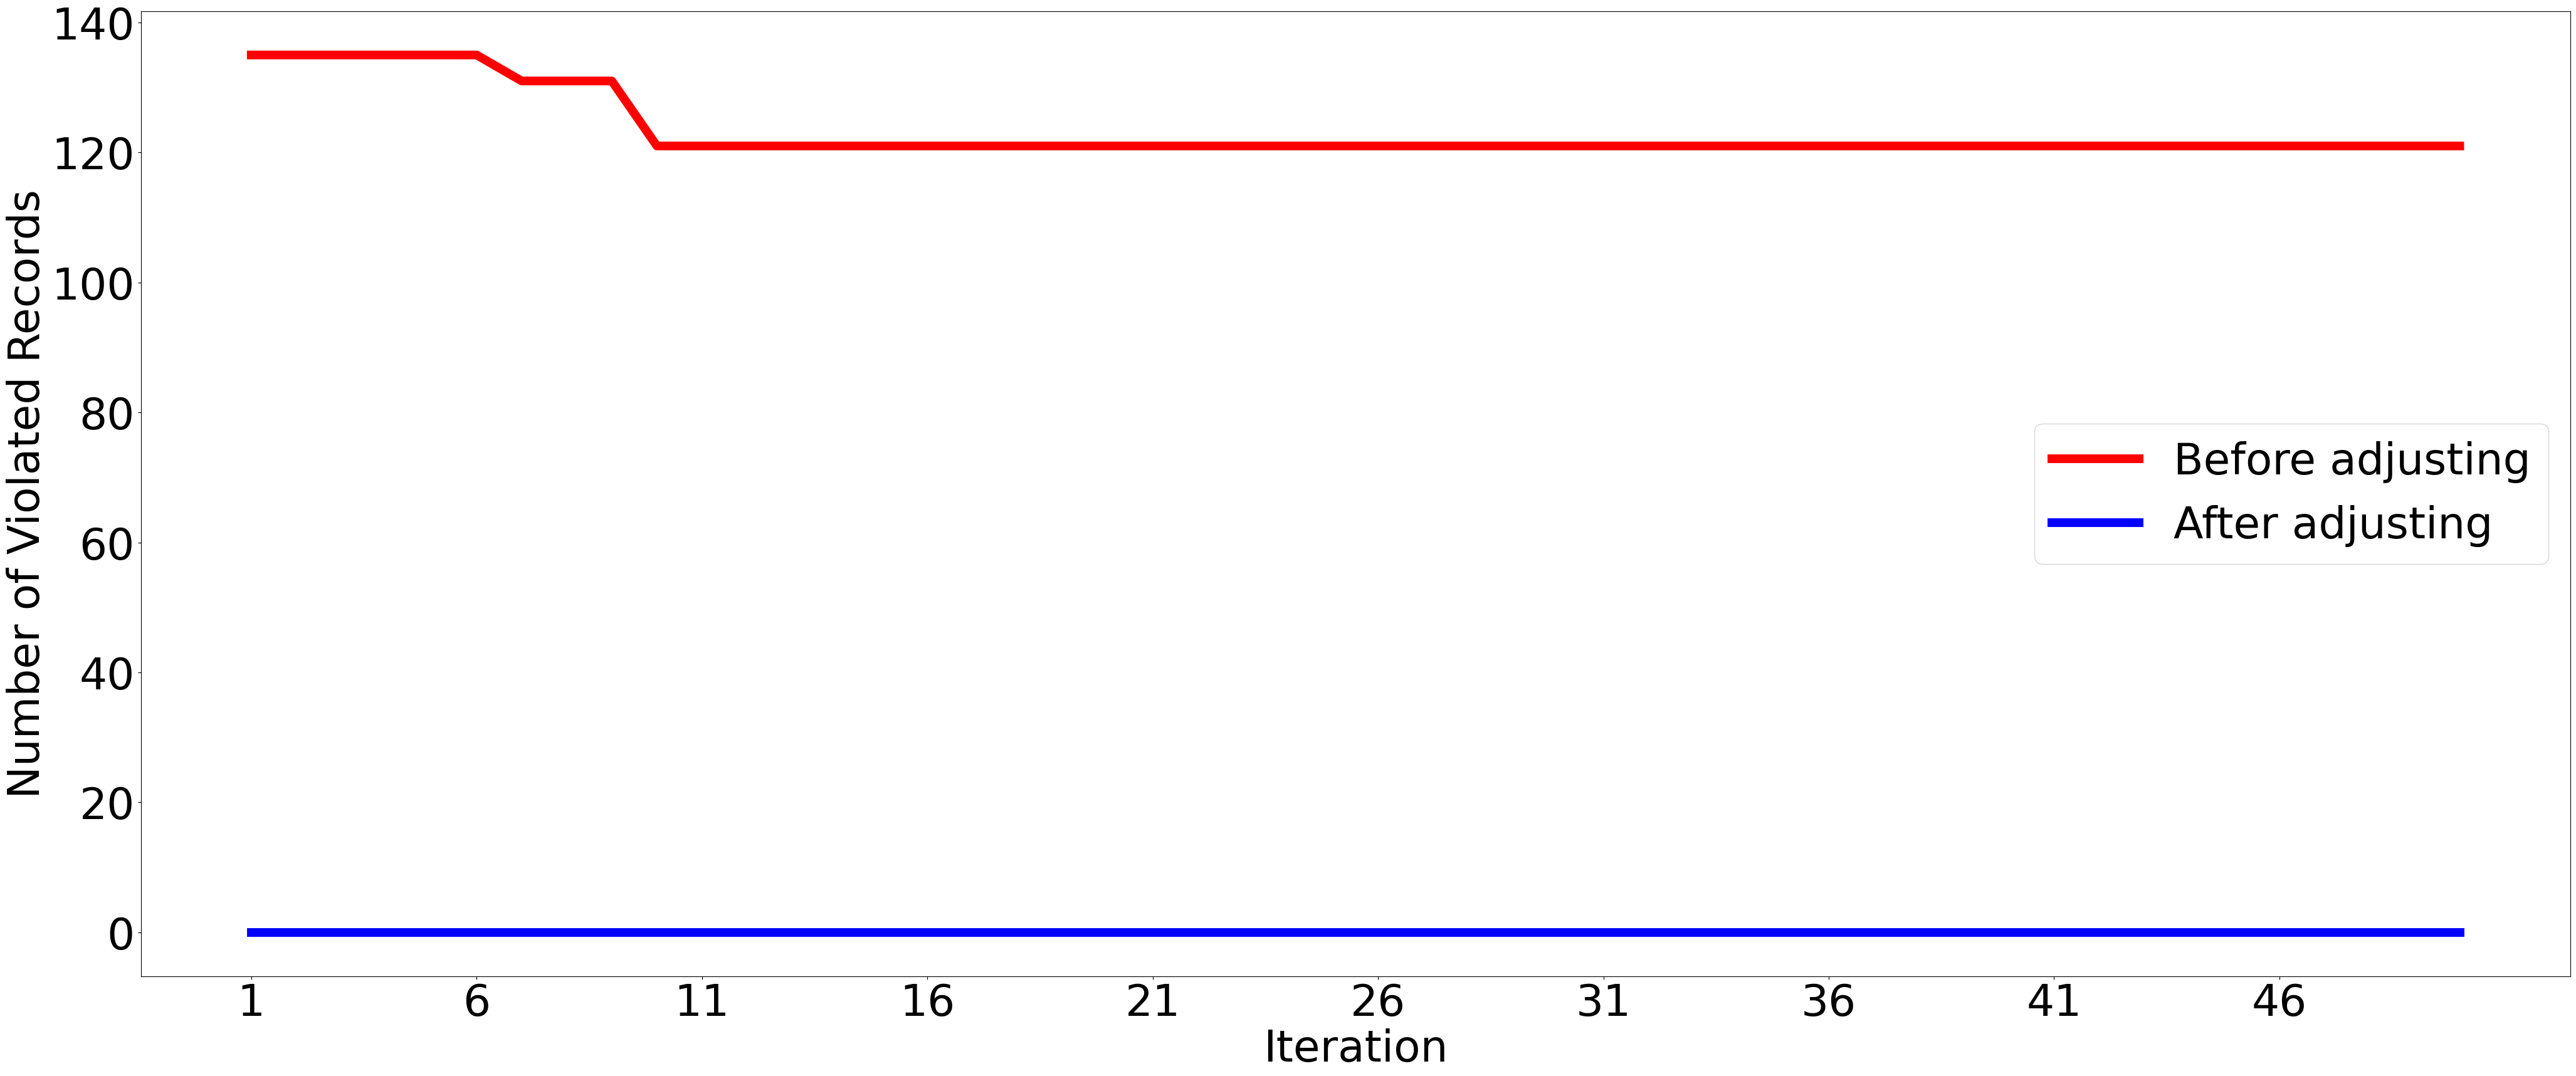

k: 20, n_cluster: 40, ML model: DT


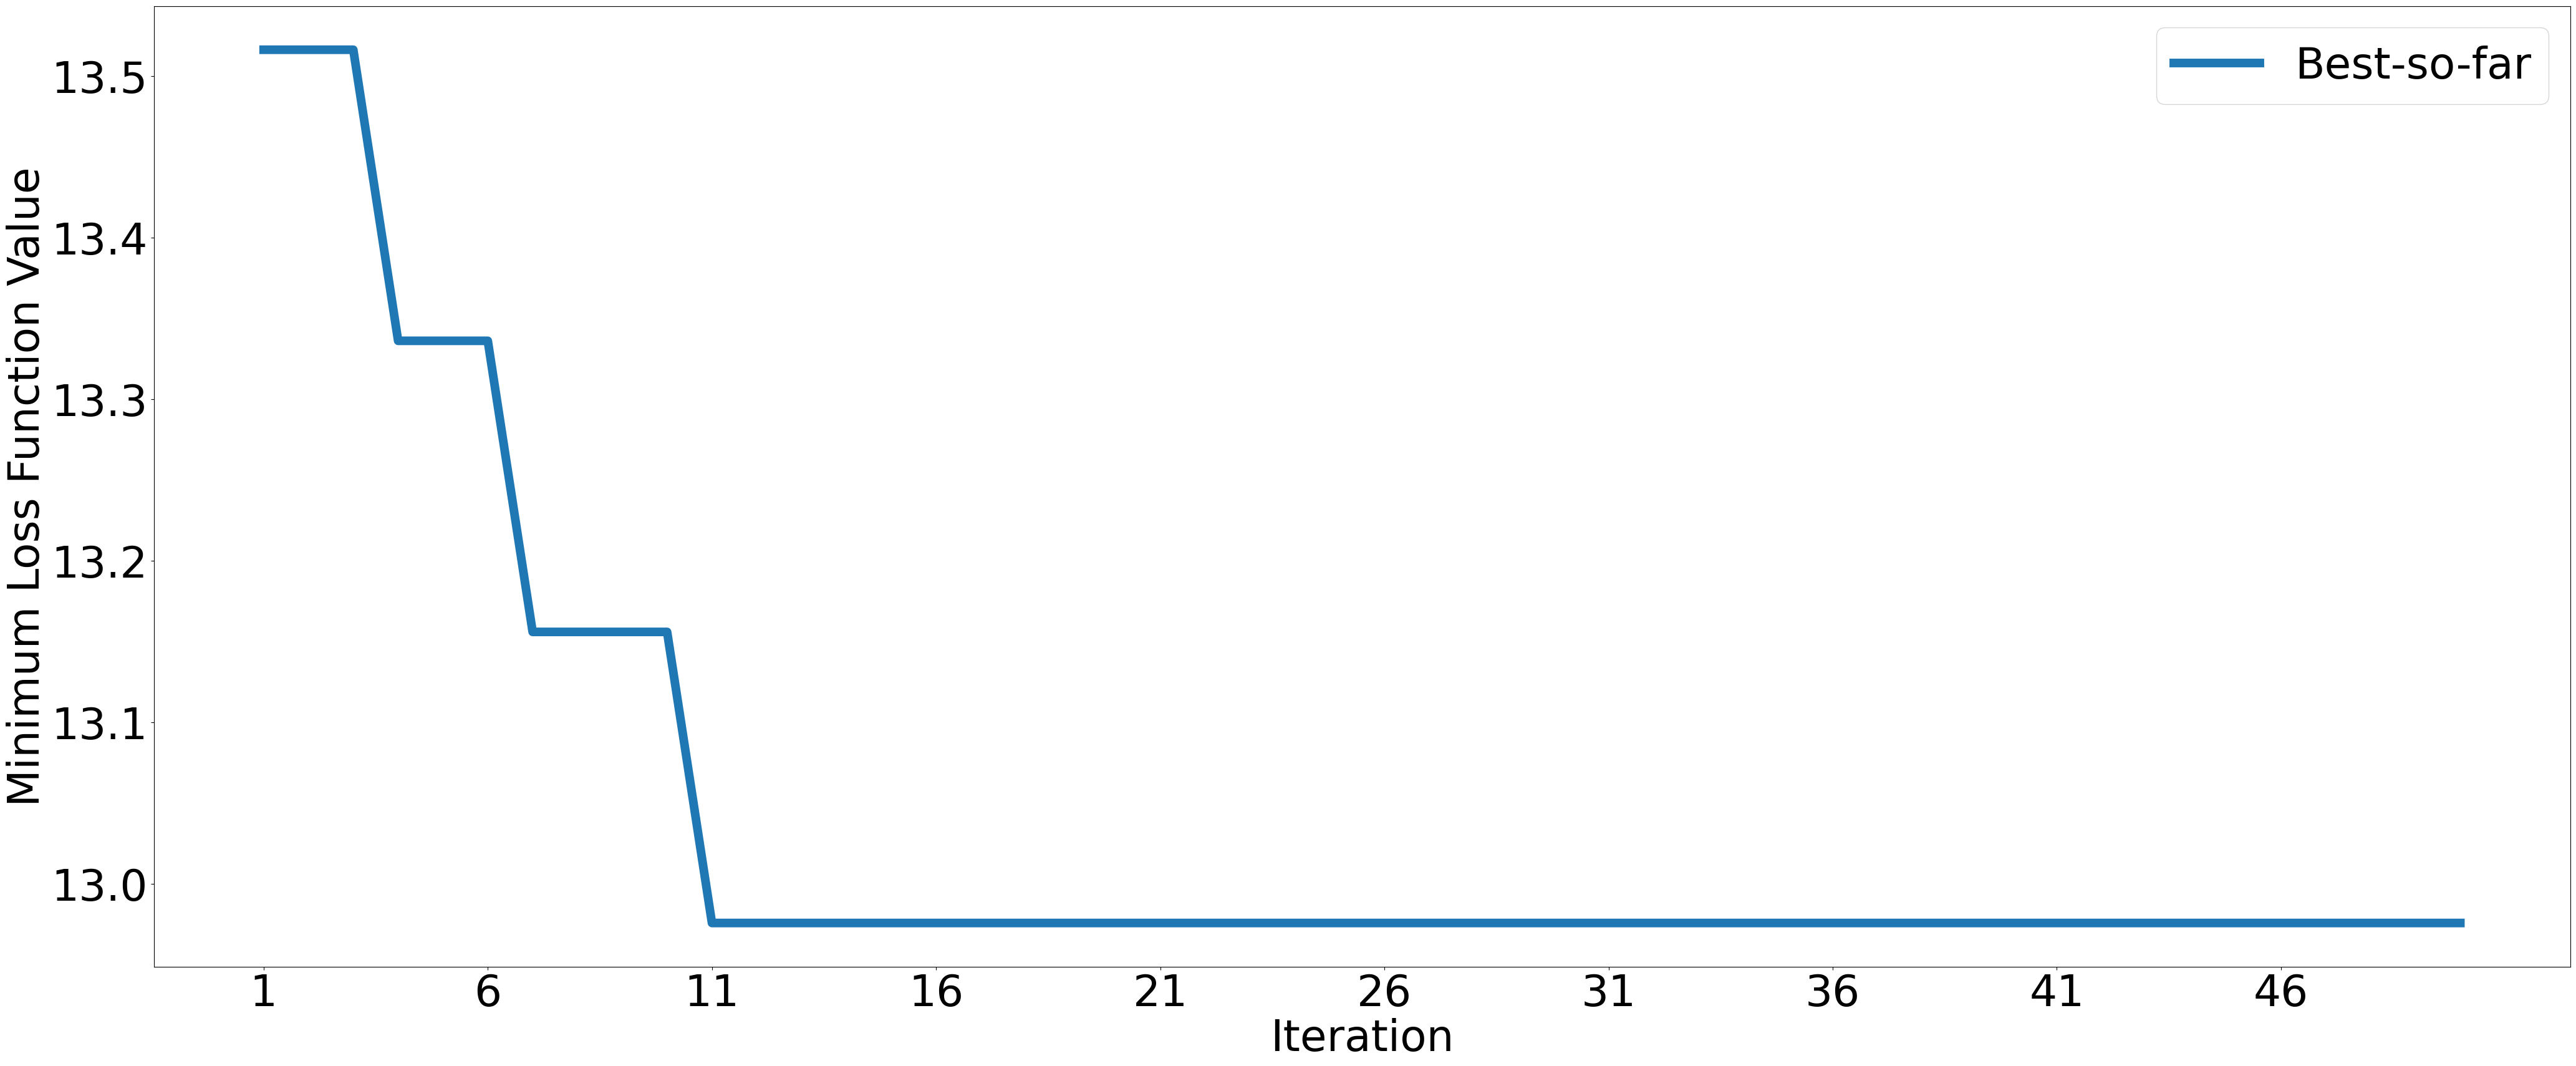

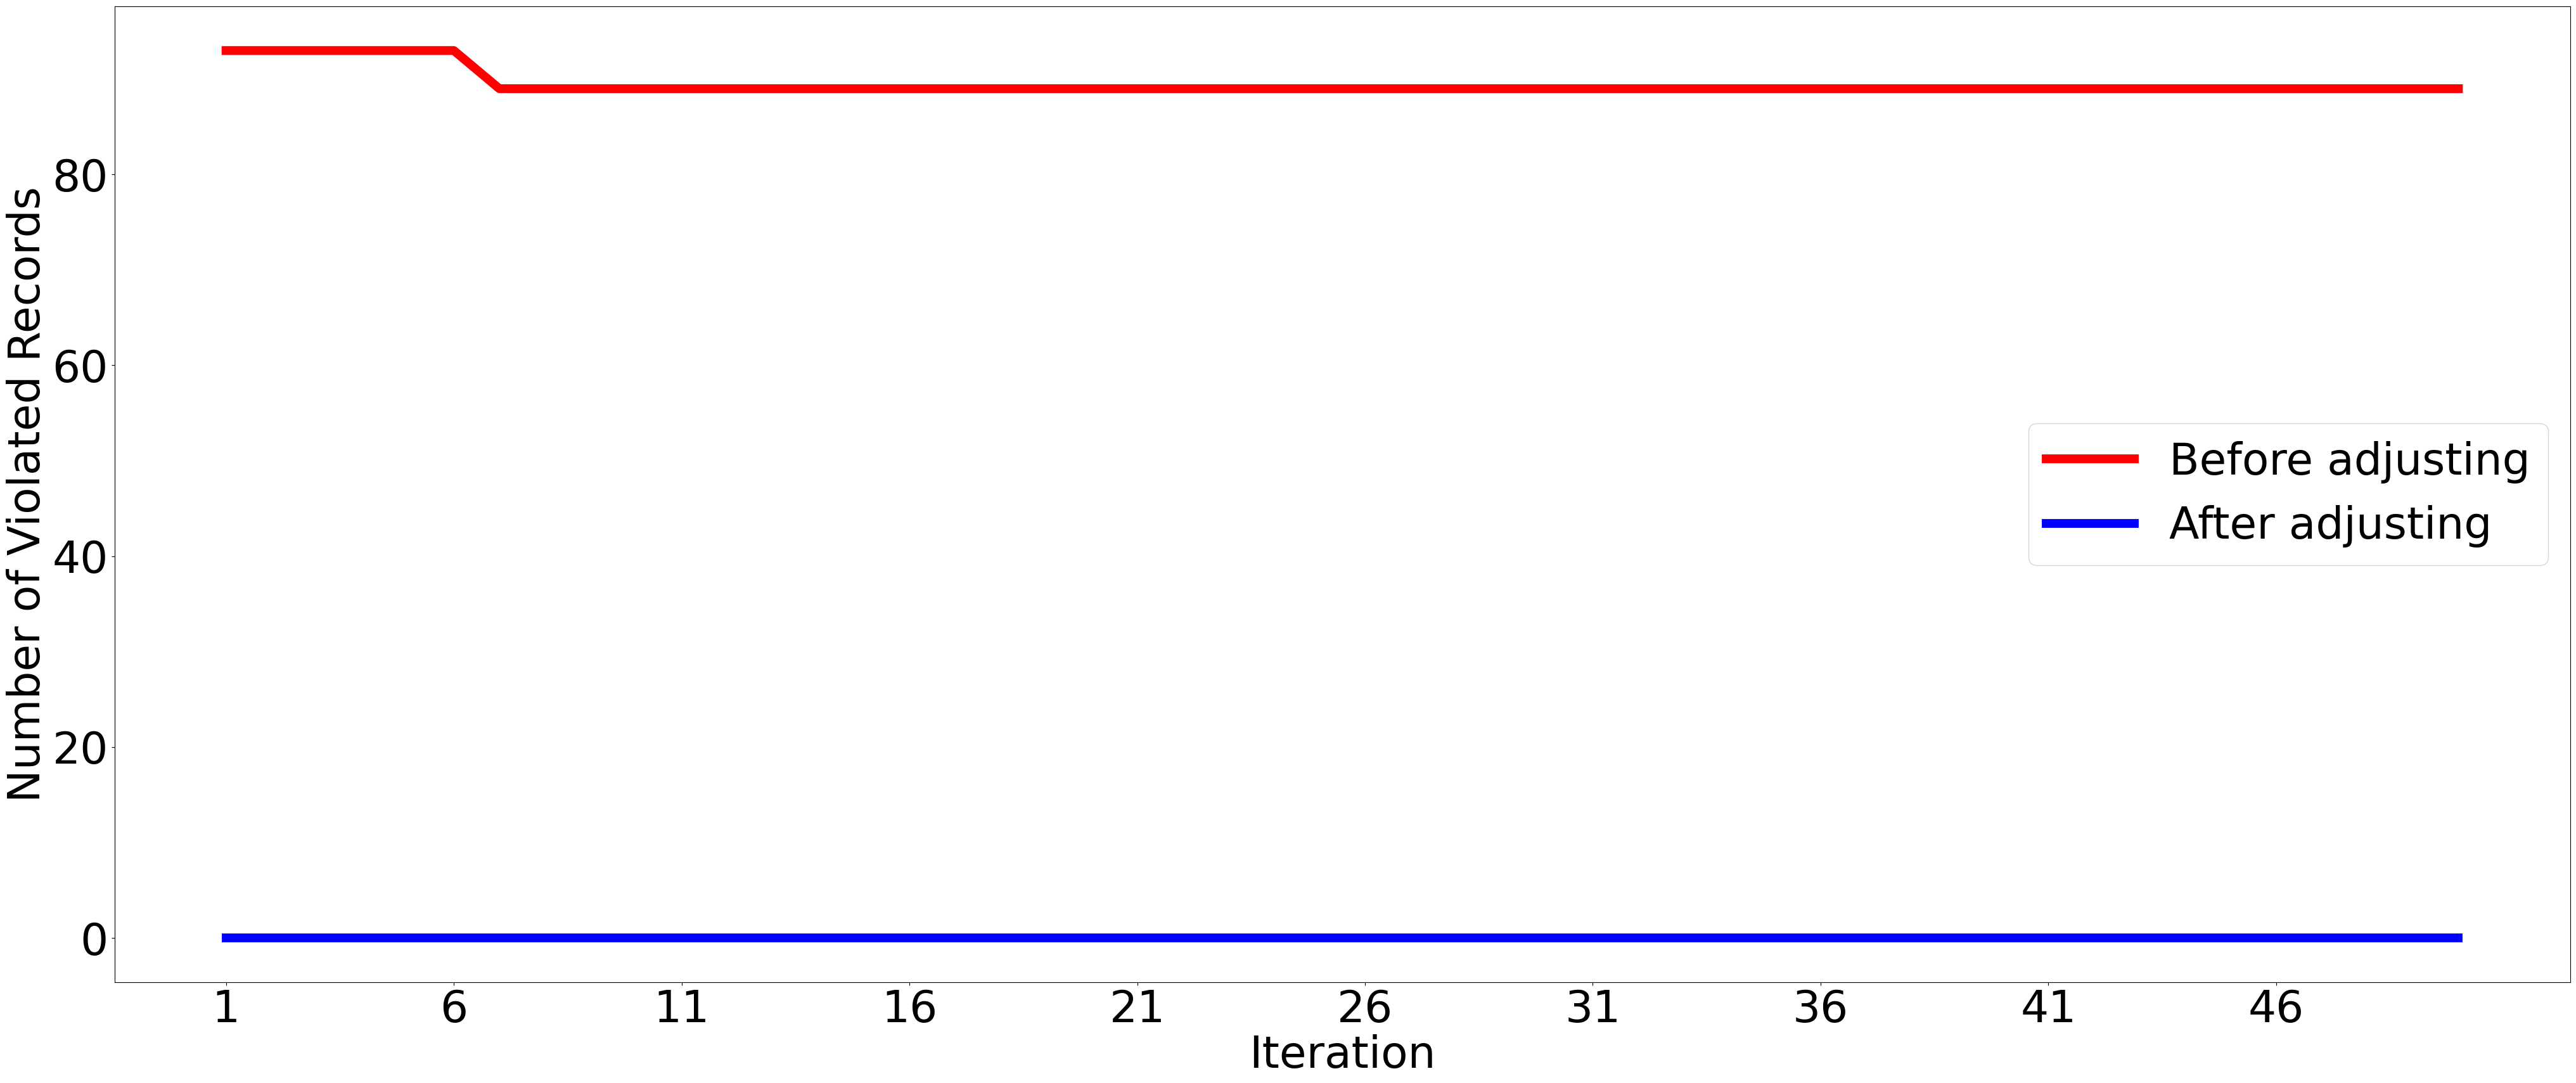

k: 20, n_cluster: 2, ML model: NB


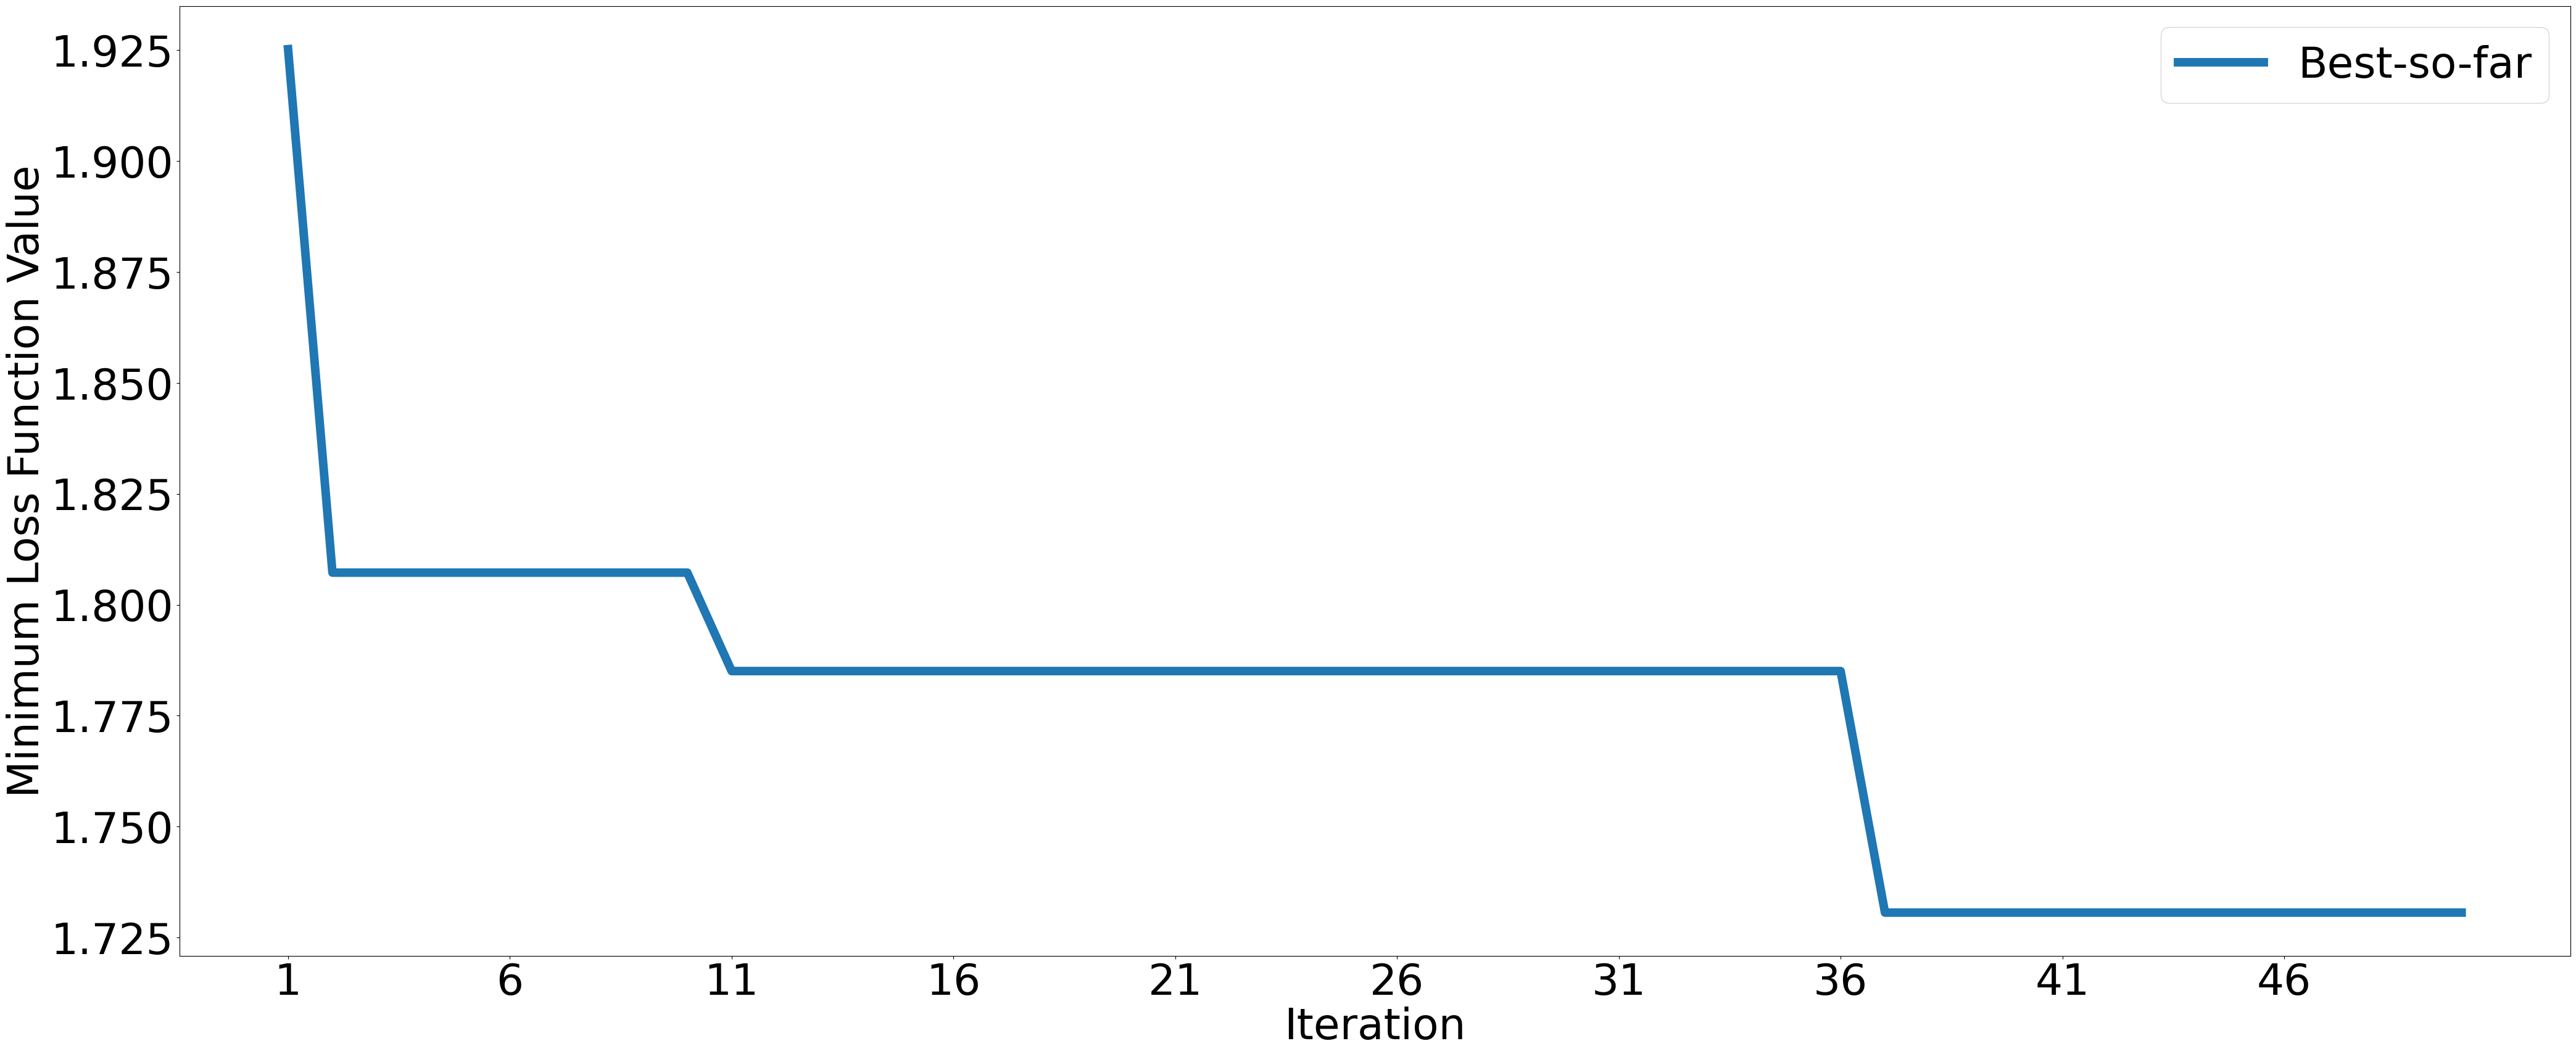

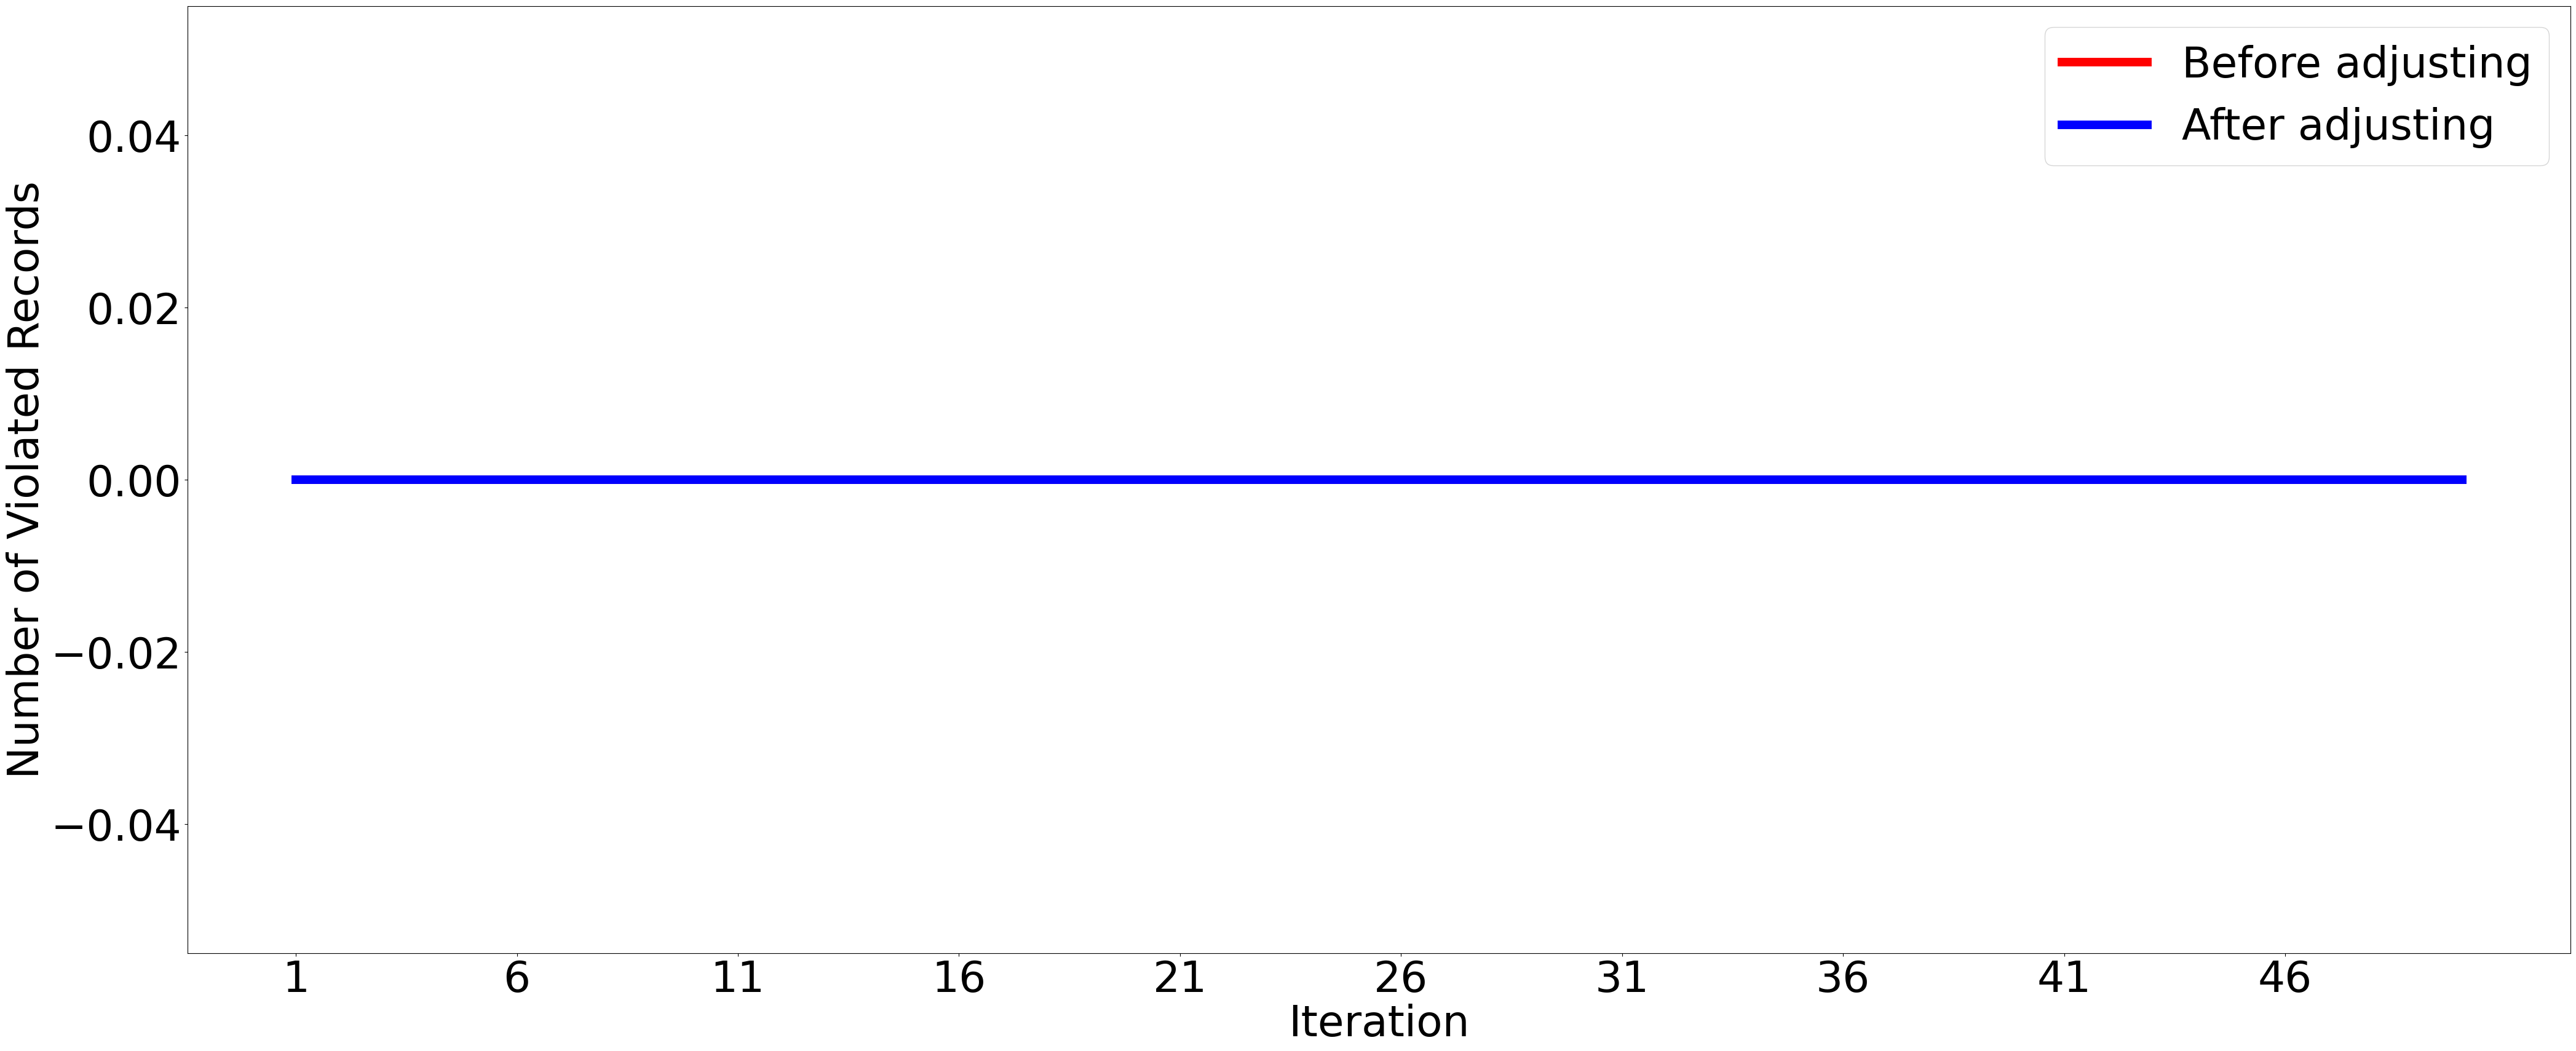

k: 20, n_cluster: 50, ML model: DT


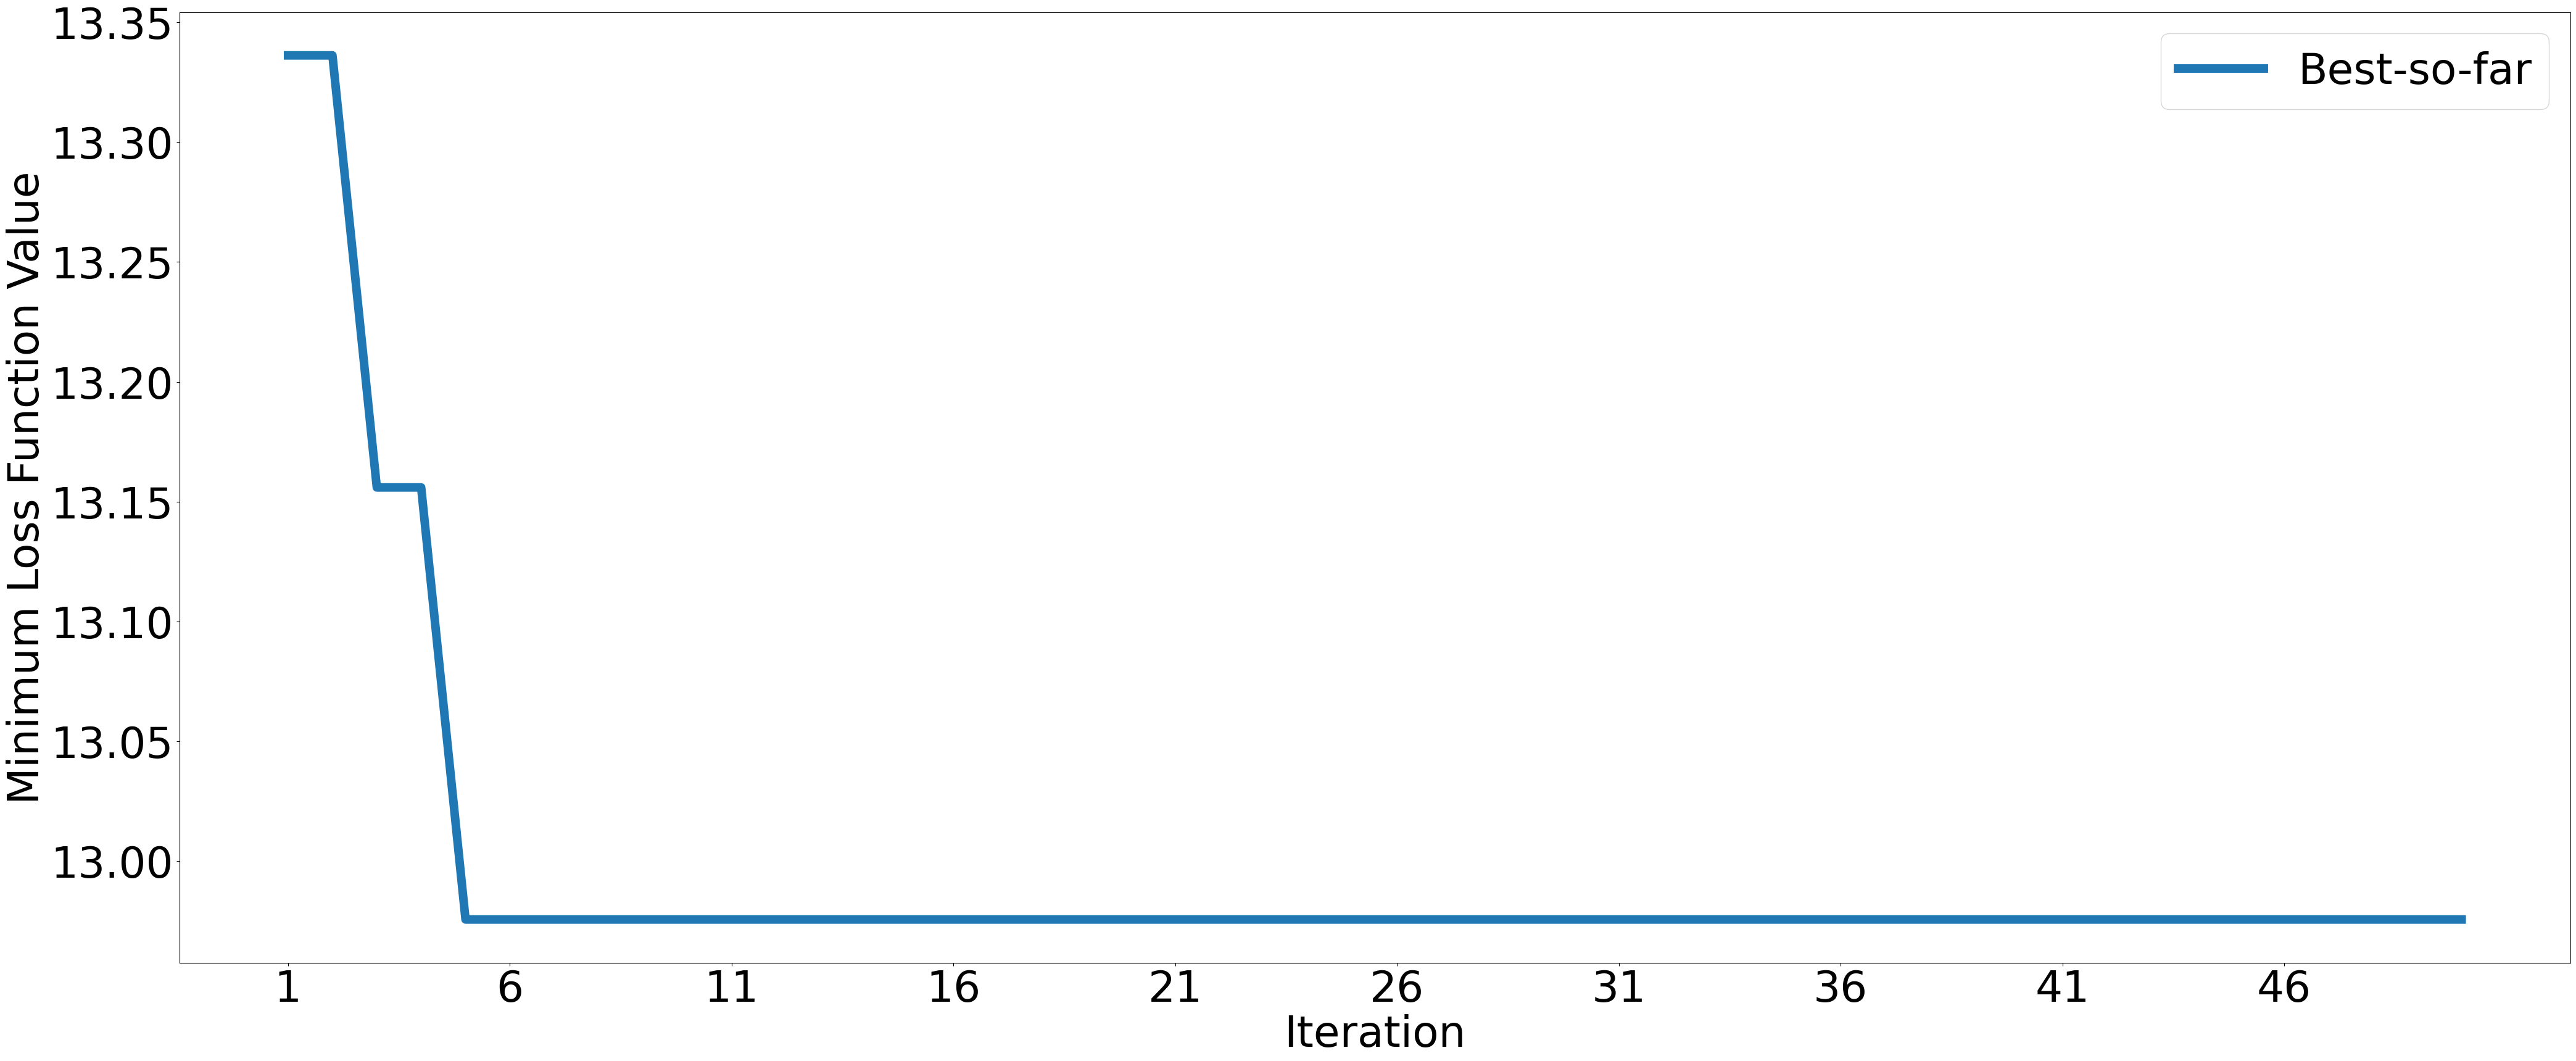

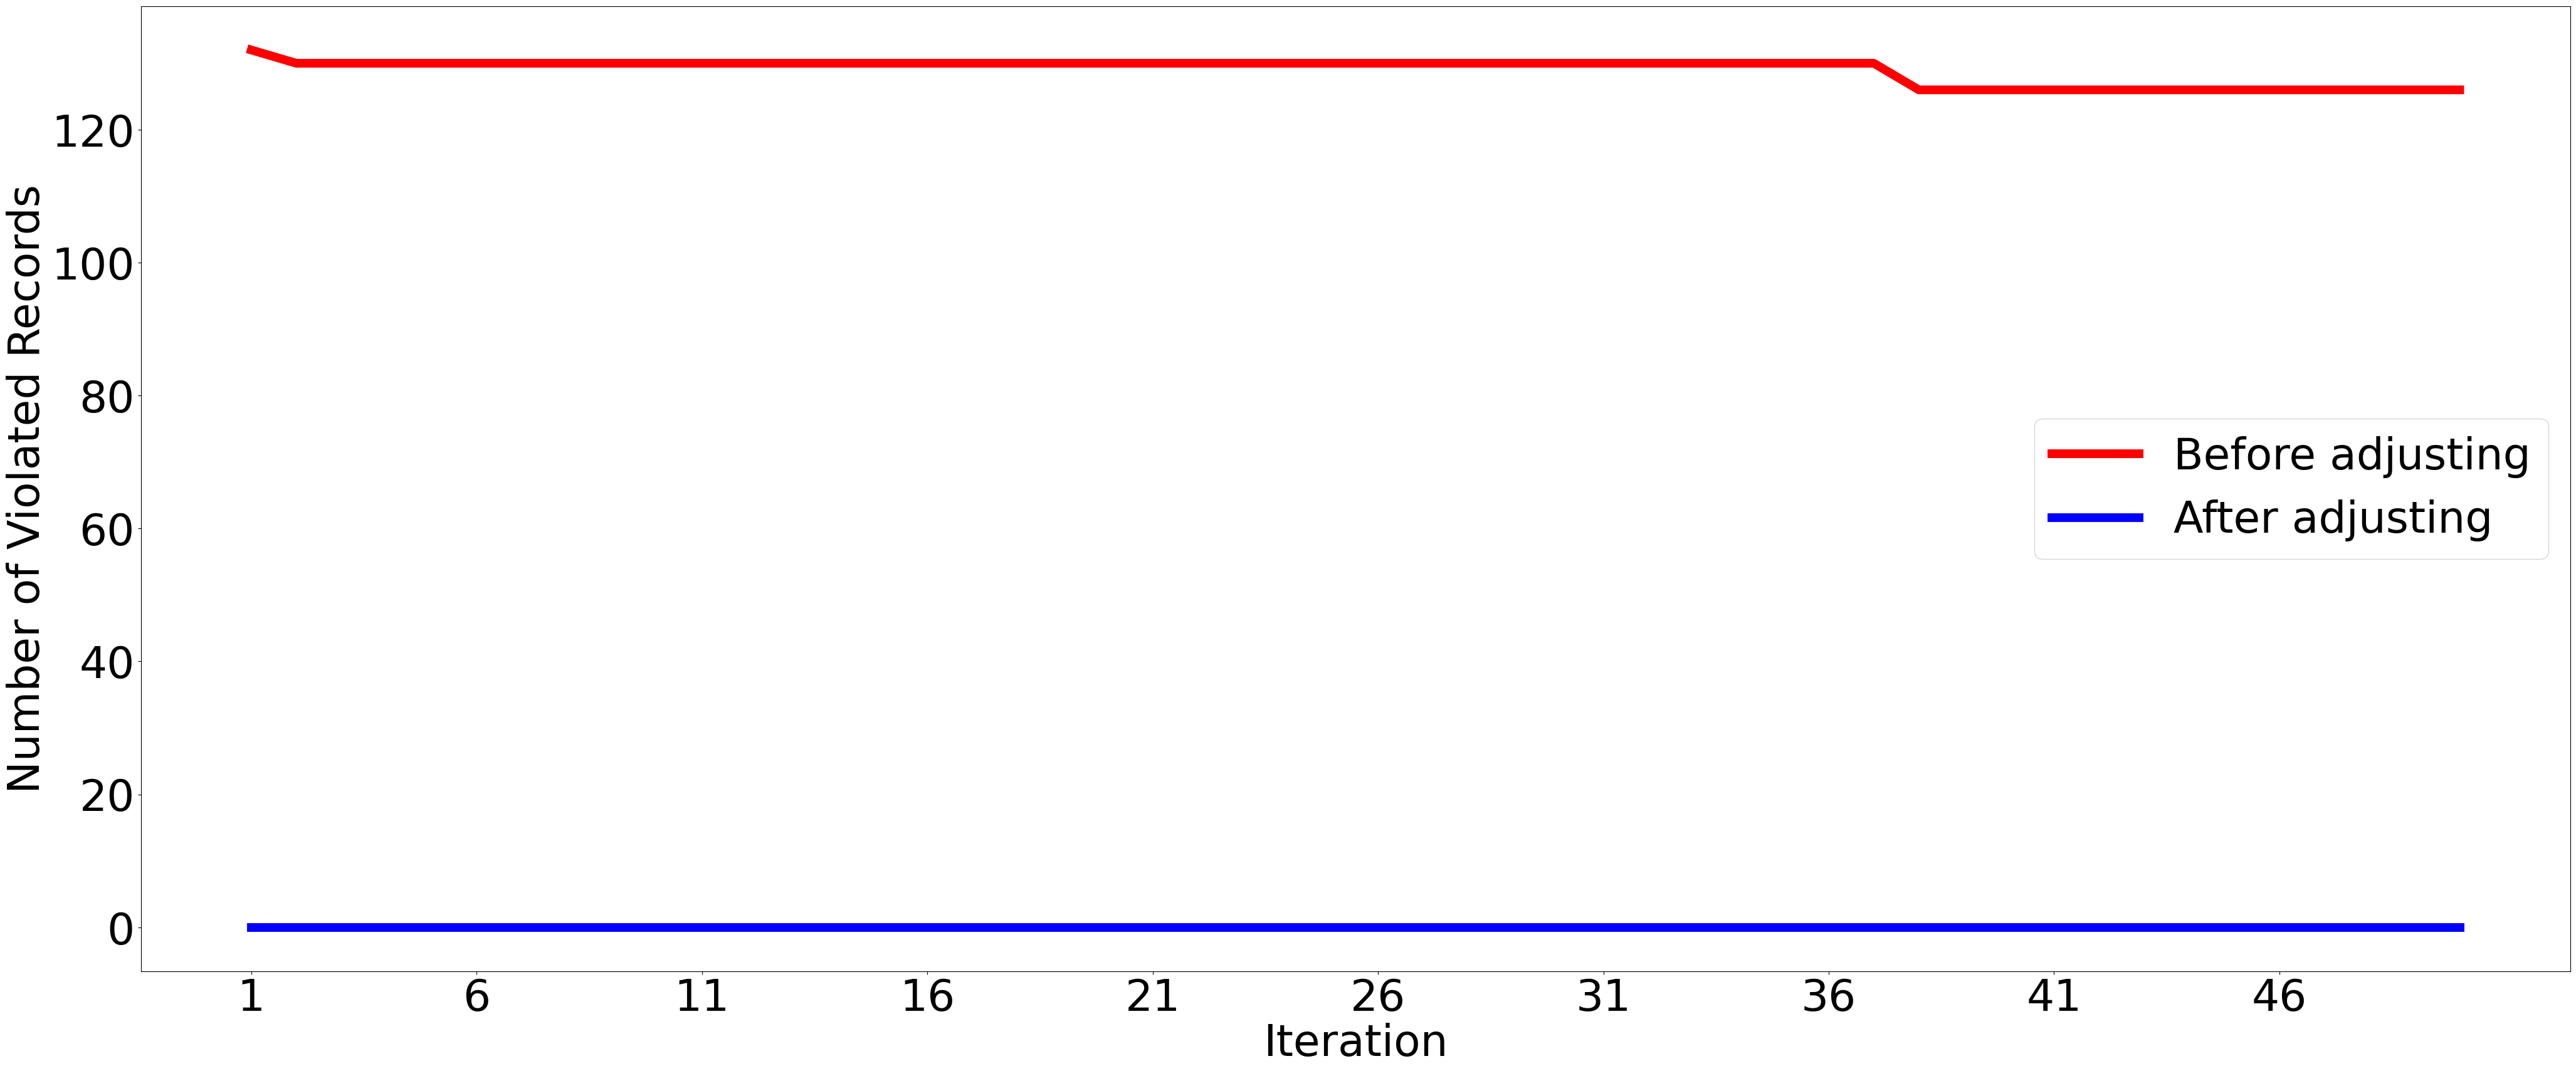

In [13]:
for file in all_files:
    info = utils.extract_info_from_filename(file, pattern)
    print(f"k: {info['k']}, n_cluster: {info['n_cluster']}, ML model: {info['model']}")

    # Load the CSV file
    file_path = os.path.join(folder_path, file)
    results_df = pd.read_csv(file_path)

    # Plot
    # utils.plot_metric_trend_for_each_particle(results_df, 'Entropy-Loss', 'Maximum Loss', agg_func='max', smooth_method='moving_avg', window_size=5, y_range=None)
    
    utils.plot_global_best_so_far(results_df, 'Entropy-Loss', 'Minimum Loss Function Value', agg_func='max', y_range=None)

    utils.plot_global_best_so_far_combined(results_df, 
                                     'num_violating_records_before_adjusting', 'Before adjusting',
                                     'num_total_violating_records_after_adjusting', 'After adjusting', 
                                     agg_func=None, y_range=None, 
                                     color_1='red', color_2='blue')